# <div style='font-size:105%; font-family:Arial'> Forecast of Number of Clicks and Bookings <span style="float:right;"> V. Ganci </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> <hr style="border-top: 2px solid black; margin-top: 2px; margin-bottom: 0px;"> </div>

Table of contents:
<ul>
    <li style='margin-bottom: 5px'><a href="#intro"> 0. Intro, Libraries & Functions </a></li>
    <li style='margin-bottom: 5px'><a href="#data"> 1. Data Overview </a></li>
    <li style='margin-bottom: 5px'><a href="#clean"> 2. Data Cleaning, Feature Engineering & EDA </a></li>
    <li style='margin-bottom: 5px'><a href="#str1"> 3. Strategy 1. Regression Model </a></li>
    <li style='margin-bottom: 5px'><a href="#str2"> 4. Strategy 2. Classification + Regression </a></li>
    <ul>
        <li style='margin-bottom: 5px'><a href="#str2_cl"> 4.1 Step 1: Classification Model </a></li>
        <li style='margin-bottom: 5px'><a href="#str2_rg"> 4.2 Step 2: Regression Model </a></li>
    </ul>
    <li style='margin-bottom: 5px'><a href="#forecast"> 5. Final Model & Forecasting </a></li>
    <li style='margin-top: 5px; margin-bottom: 10px'><a href="#conclusion"> 6. Insights and Next Step </a></li>
</ul>


<a id='intro'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Intro, Libraries & Functions   <span style="float:right;"> 0. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In this notebook I showcase my skills in tackling a data science project which focuses on the analysis and modeling of a sparse dataset.

The dataset contains information on different hotels and the daily number of clicks and bookings made by customers.

The goal of the case study is to forecast the conversion rate, i.e. the ratio between the number of bookings and the number of clickouts, in 2023.08.11 for each hotel-advertiser couple present in the metrics dataset. 
The dataset span 10 days between 2023.08.01 to 2023.08.10. An additional dataset, the hotels one, contains information about each hotel, that could help in the conversion rate prediction.

After the phases of data cleaning, EDA, and feature engineering, the best strategy presented in this notebook to predict the target variable, consists of a first classification model and a subsequent regression model, mimicking the concept of a Hurdle modle.
The classification model predicts if the conversion rate is going to be zero or higher than zero.
The regression model improves the conversion rate predictions for the hotel-advertiser couples that were predicted to have a conversion rate higher than zero.

I conclude the notebook with a summary of the results and the possible next steps.

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import datetime as dt
from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(6,2)}, style='whitegrid')

from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, r2_score

import pickle

# Filtering out FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def outliers(feature):
    # returns lower- and upper-limit to define outliers in a feature
    percentile25 = feature.quantile(0.25)
    percentile75 = feature.quantile(0.75)   
    iqr = percentile75 - percentile25
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    return([lower_limit, upper_limit])


def generate_combinations(strings):
    # returns all the combinations for a list of strings
    all_combinations = []
    
    for r in range(1, len(strings) + 1):
        combinations_list = list(combinations(strings, r))
        combinations_list = [list(comb) for comb in combinations_list]
        all_combinations.extend(combinations_list)
        
    return all_combinations

<a id='data'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Data Overview  <span style="float:right;"> 1. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

Let's take a first look at the datasets.

In [3]:
# Load dataset

df_hotels_0 = pd.read_csv('Data/hotels.csv')
df_metrics_0 = pd.read_csv('Data/metrics.csv')

In [4]:
# Checking for duplicates

print('The hotels dataset has', df_hotels_0.duplicated().sum(), 'duplicate rows.\n')
print('The metrics dataset has', df_metrics_0.duplicated().sum(), 'duplicate rows.')

The hotels dataset has 0 duplicate rows.

The metrics dataset has 0 duplicate rows.


In [5]:
df_hotels_0.head(2)

,hotel_id,stars,n_reviews,rating,city_id
0,1,3,3601.0,6.1,36
1,2,3,1949.0,8.6,36


In [6]:
df_hotels_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hotel_id   224 non-null    int64  
 1   stars      224 non-null    int64  
 2   n_reviews  223 non-null    float64
 3   rating     223 non-null    float64
 4   city_id    224 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 8.9 KB


We note that the hotels dataset has 2 null entries, 1 in the 'n_reviews' column and 1 in the 'rating' column.

Let's check for consistency if each hotel has only 1 entry.

In [7]:
df_hotels_0['hotel_id'].duplicated().sum()

0

In [8]:
df_hotels_0[df_hotels_0['n_reviews'].isna()]

,hotel_id,stars,n_reviews,rating,city_id
215,216,0,NaN,NaN,3


The null entries correspond to only one hotel with id = 216.

Let's see how the different features are distributed.

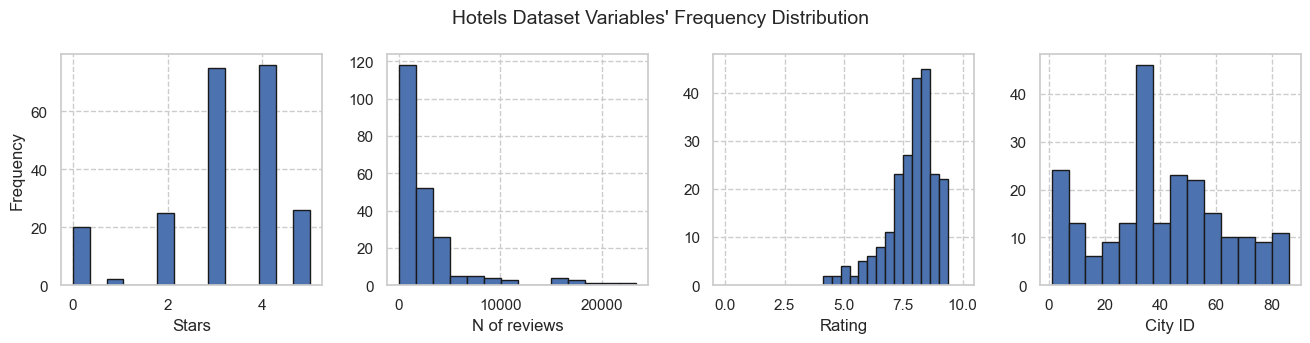

In [9]:
fig1, ax = plt.subplots(1, 4, figsize = (16,3))
plt.subplots_adjust(wspace=0.25)

bins = int(np.sqrt(len(df_hotels_0)))

fig1.suptitle("Hotels Dataset Variables' Frequency Distribution", y=1.03, fontsize=14)

ax[0].hist(df_hotels_0.stars, bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0].set(xlabel='Stars', ylabel='Frequency')

ax[1].hist(df_hotels_0['n_reviews'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[1].set(xlabel='N of reviews', ylabel='')

ax[2].hist(df_hotels_0.rating, bins=bins, color='C0', edgecolor='k', zorder=2)
ax[2].axis([-0.5,10.5,0,48])
ax[2].set(xlabel='Rating', ylabel='')

ax[3].hist(df_hotels_0['city_id'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[3].set(xlabel='City ID', ylabel='')

for x in range(4):
    ax[x].grid(ls='--', zorder=0)

plt.show()
#fig1.savefig('HotelDataset.jpg', dpi=250, bbox_inches='tight')

In [10]:
df_hotels_0[['city_id']].value_counts().reset_index().head(5)

,city_id,count
0,34,31
1,46,15
2,51,12
3,3,10
4,11,8


1. The stars distribution is quite normal, with a few outliers in the 0 stars category.
2. The n_reviews distribution is right-skewed, with the presence of outliers.
3. The rating distribution is nearly normal, with a slight left tail.
4. The city ID count distribution is almost uniform, with a prominent exception for city_id = 34

In [11]:
df_hotels_0.describe()

,hotel_id,stars,n_reviews,rating,city_id
count,224.000000,224.000000,223.000000,223.000000,224.000000
mean,112.500000,3.174107,2960.426009,7.869507,40.419643
std,64.807407,1.316010,3889.407608,1.046686,22.100317
min,1.000000,0.000000,10.000000,4.100000,1.000000
25%,56.750000,3.000000,956.500000,7.400000,26.000000
50%,112.500000,3.000000,1588.000000,8.000000,38.500000
75%,168.250000,4.000000,3260.000000,8.600000,54.250000
max,224.000000,5.000000,23376.000000,9.400000,86.000000


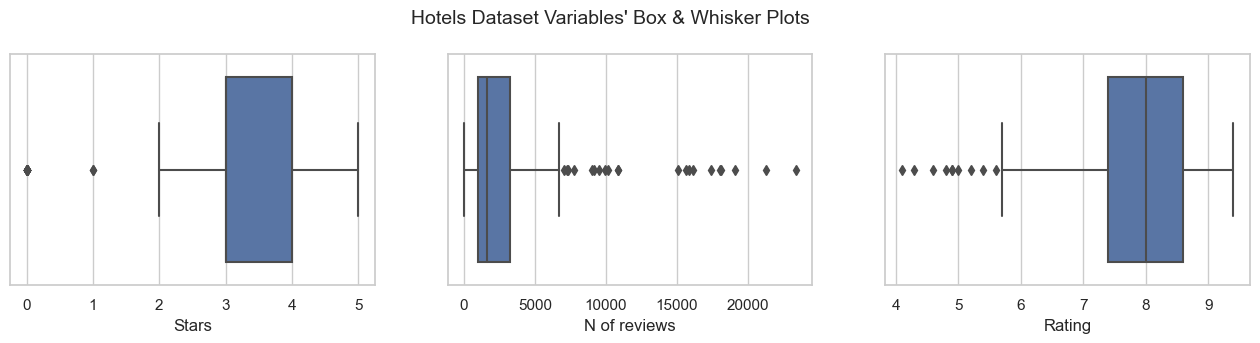

In [12]:
fig2, ax = plt.subplots(1, 3, figsize = (16,3))
plt.subplots_adjust(wspace=0.2)

fig2.suptitle("Hotels Dataset Variables' Box & Whisker Plots", y=1.03, fontsize=14)

sns.boxplot(df_hotels_0.stars, orient='h', ax=ax[0])
ax[0].set(xlabel='Stars', ylabel='')

sns.boxplot(df_hotels_0['n_reviews'], orient='h', ax=ax[1])
ax[1].set(xlabel='N of reviews', ylabel='')

sns.boxplot(df_hotels_0.rating, orient='h', ax=ax[2])
ax[2].set(xlabel='Rating', ylabel='')

for x in range(3):
    ax[x].set_yticks([])
    ax[x].set_yticklabels([])

plt.show()

The statical metrics and the box & Whisker plots confirm the presence of outliers.



In [13]:
df_metrics_0.head(2)

,ymd,hotel_id,advertiser_id,n_clickouts,n_bookings
0,20230801,1,1,5,0
1,20230801,1,5,159,5


In [14]:
df_metrics_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10292 entries, 0 to 10291
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   ymd            10292 non-null  int64
 1   hotel_id       10292 non-null  int64
 2   advertiser_id  10292 non-null  int64
 3   n_clickouts    10292 non-null  int64
 4   n_bookings     10292 non-null  int64
dtypes: int64(5)
memory usage: 402.2 KB


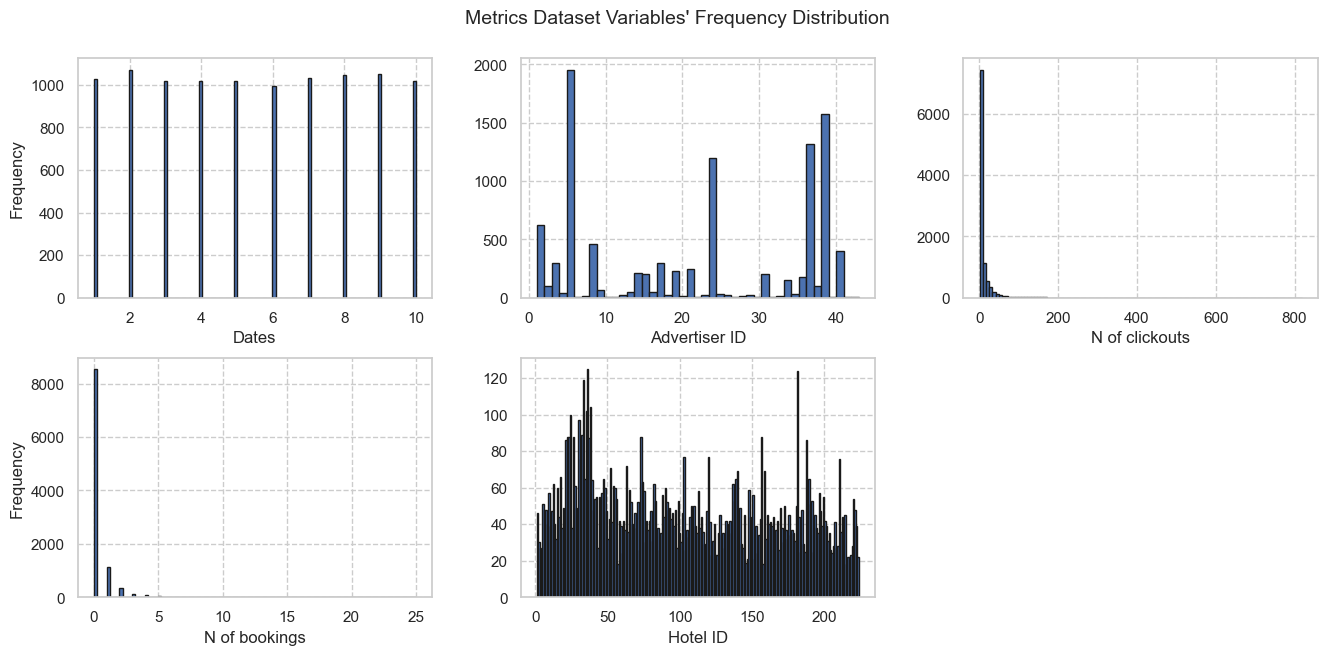

In [15]:
fig3, ax = plt.subplots(2, 3, figsize = (16,7))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

bins = int(np.sqrt(len(df_metrics_0)))

fig3.suptitle("Metrics Dataset Variables' Frequency Distribution", y=0.95, fontsize=14)

ax[0,0].hist(df_metrics_0['ymd']-df_metrics_0['ymd'][0]+1, bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0,0].set(xlabel='Dates', ylabel='Frequency')

ax[0,1].hist(df_metrics_0['advertiser_id'], bins=43, color='C0', edgecolor='k', zorder=2)
ax[0,1].set(xlabel='Advertiser ID', ylabel='')

ax[0,2].hist(df_metrics_0['n_clickouts'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0,2].set(xlabel='N of clickouts', ylabel='')

ax[1,0].hist(df_metrics_0['n_bookings'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[1,0].set(xlabel='N of bookings', ylabel='Frequency')

ax[1,1].hist(df_metrics_0['hotel_id'], bins=224, color='C0', edgecolor='k', zorder=2)
ax[1,1].set(xlabel='Hotel ID', ylabel='')

ax[1,2].axis('off')

for x in range(3):
    for y in range(2):
        ax[y,x].grid(ls='--', zorder=0)

plt.show()
#fig3.savefig('MetricDataset.jpg', dpi=250, bbox_inches='tight')

1. We note highly right-skewed distributions for the n_clickouts and n_bookings features. 
2. Each date has a similar number of entries.
3. Some hotels and especially few advertisers have more entries than others.

In [16]:
df_metrics_0.describe()

,ymd,hotel_id,advertiser_id,n_clickouts,n_bookings
count,1.029200e+04,10292.000000,10292.000000,10292.000000,10292.000000
mean,2.023081e+07,103.311601,21.663136,13.387583,0.334629
std,2.881235e+00,64.945603,14.530521,41.079112,1.247971
min,2.023080e+07,1.000000,1.000000,1.000000,0.000000
25%,2.023080e+07,42.000000,5.000000,1.000000,0.000000
50%,2.023080e+07,97.000000,24.000000,3.000000,0.000000
75%,2.023081e+07,160.000000,37.000000,11.000000,0.000000
max,2.023081e+07,224.000000,43.000000,818.000000,25.000000


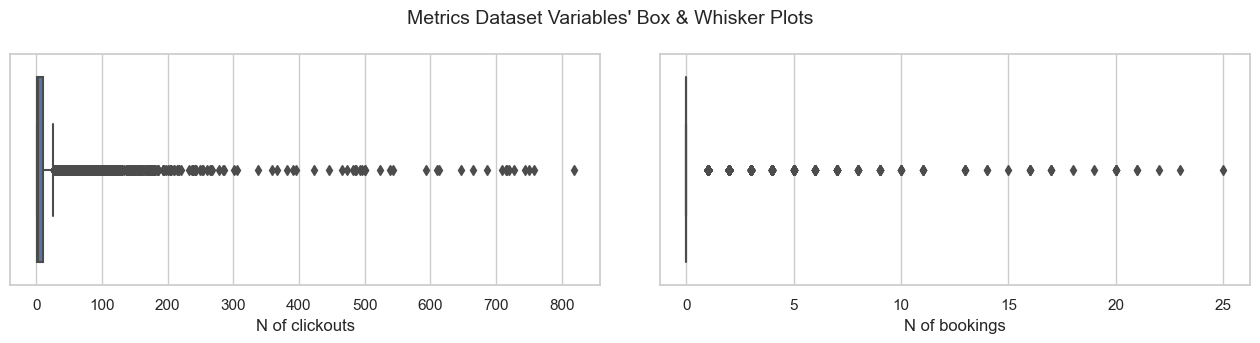

In [17]:
fig4, ax = plt.subplots(1, 2, figsize = (16,3))
plt.subplots_adjust(wspace=0.1)

fig4.suptitle("Metrics Dataset Variables' Box & Whisker Plots", y=1.03, fontsize=14)

sns.boxplot(df_metrics_0['n_clickouts'], orient='h', ax=ax[0])
ax[0].set(xlabel='N of clickouts', ylabel='')

sns.boxplot(df_metrics_0['n_bookings'], orient='h', ax=ax[1])
ax[1].set(xlabel='N of bookings', ylabel='')

for x in range(2):
    ax[x].set_yticks([])
    ax[x].set_yticklabels([])

plt.show()

In the case of the n_clickouts and n_bookings, we cannot consider outliers the values higher than 0.75 percentile. They are an intrinsinc characteristic of the dataset.

<a id='clean'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Data Cleaning, Feature Engineering & EDA <span style="float:right;"> 2. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In [18]:
# Merging the two datasets

df_merged_original = pd.merge(df_metrics_0, df_hotels_0, how='left', on='hotel_id')

df_merged = df_merged_original.copy()

df_merged.head(2)

,ymd,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id
0,20230801,1,1,5,0,3,3601.0,6.1,36
1,20230801,1,5,159,5,3,3601.0,6.1,36


In [19]:
# Convert dates to pandas datetime format

df_merged['date'] = pd.to_datetime(df_merged['ymd'], format='%Y%m%d')

# Sorting data by 'date'

df_merged.sort_values(by=['date'], inplace=True, ascending=True)

# Creating day, weekday, is_weekend, columns

df_merged['day'] = df_merged['date'].dt.day
df_merged['weekday'] = df_merged['date'].dt.weekday
df_merged['is_weekend'] = df_merged['weekday'].apply(lambda x: 1 if x >= 5 else 0)
df_merged.drop('ymd', axis=1, inplace=True)

df_merged.head(2)

,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id,date,day,weekday,is_weekend
0,1,1,5,0,3,3601.0,6.1,36,2023-08-01,1,1,0
677,135,39,9,0,5,531.0,7.8,60,2023-08-01,1,1,0


In [20]:
book_click_daily = df_merged.groupby('date')[['n_clickouts','n_bookings']].sum().reset_index()
book_click_daily

,date,n_clickouts,n_bookings
0,2023-08-01,13551,347
1,2023-08-02,13459,371
2,2023-08-03,13343,343
3,2023-08-04,13614,383
4,2023-08-05,13838,375
5,2023-08-06,14716,345
6,2023-08-07,14864,356
7,2023-08-08,14387,328
8,2023-08-09,13772,330
9,2023-08-10,12241,266


In [21]:
book_click_daily[book_click_daily['date'] < '2023-08-10'].mean()

date           2023-08-05 00:00:00
n_clickouts           13949.333333
n_bookings              353.111111
dtype: object

Each date shares similar numbers of clickouts and bookings, except for the last day, where the number of bookings decreased.

In [22]:
# Checking entries with nan values

df_merged[df_merged['hotel_id'] == 216]

,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id,date,day,weekday,is_weekend
1004,216,1,1,0,0,NaN,NaN,3,2023-08-01,1,1,0
1005,216,4,3,0,0,NaN,NaN,3,2023-08-01,1,1,0
2070,216,1,1,0,0,NaN,NaN,3,2023-08-02,2,2,0
2071,216,4,51,0,0,NaN,NaN,3,2023-08-02,2,2,0
3088,216,1,1,0,0,NaN,NaN,3,2023-08-03,3,3,0
3089,216,4,80,1,0,NaN,NaN,3,2023-08-03,3,3,0
4110,216,4,98,1,0,NaN,NaN,3,2023-08-04,4,4,0
5124,216,4,97,1,0,NaN,NaN,3,2023-08-05,5,5,1
5125,216,38,1,0,0,NaN,NaN,3,2023-08-05,5,5,1
6118,216,17,1,0,0,NaN,NaN,3,2023-08-06,6,6,1


I decided to imput the NaN values based on the median values of the zero stars hotels and the values of the hotels in city_id = 3.

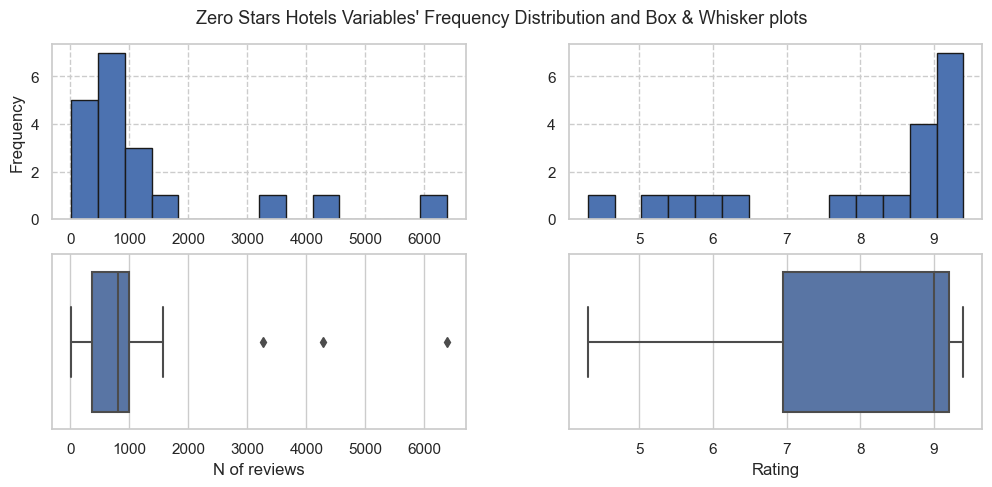

In [23]:
fig5, ax = plt.subplots(2, 2, figsize = (12,5))
plt.subplots_adjust(wspace=0.25)

bins = int(np.sqrt(len(df_hotels_0)))

fig5.suptitle("Zero Stars Hotels Variables' Frequency Distribution and Box & Whisker plots", y=0.95, fontsize=13)

ax[0,0].hist(df_hotels_0[df_hotels_0['stars'] == 0]['n_reviews'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0,0].set(xlabel='', ylabel='Frequency')

ax[0,1].hist(df_hotels_0[df_hotels_0['stars'] == 0]['rating'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0,1].set(xlabel='', ylabel='')

for x in range(2):
    ax[0,x].grid(ls='--', zorder=0)
    
sns.boxplot(df_hotels_0[df_hotels_0['stars'] == 0][['n_reviews']], orient='h', ax=ax[1,0])
ax[1,0].set(xlabel='N of reviews', ylabel='')

sns.boxplot(df_hotels_0[df_hotels_0['stars'] == 0][['rating']], orient='h', ax=ax[1,1])
ax[1,1].set(xlabel='Rating', ylabel='')

for x in range(2):
    ax[1,x].set_yticks([])
    ax[1,x].set_yticklabels([])

plt.show()

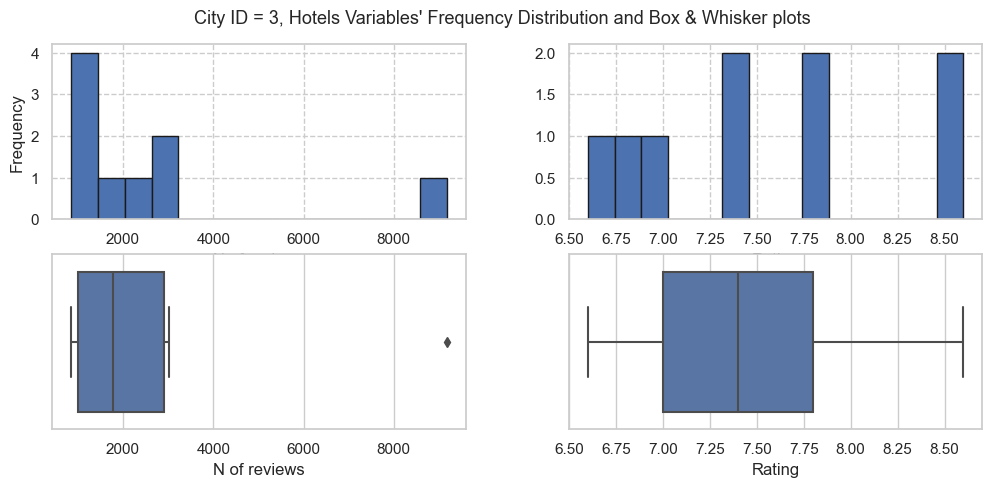

In [24]:
fig6, ax = plt.subplots(2, 2, figsize = (12,5))
plt.subplots_adjust(wspace=0.25)

bins = int(np.sqrt(len(df_hotels_0)))

fig6.suptitle("City ID = 3, Hotels Variables' Frequency Distribution and Box & Whisker plots", y=0.95, fontsize=13)

ax[0,0].hist(df_hotels_0[df_hotels_0['city_id'] == 3]['n_reviews'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0,0].set(xlabel='N of reviews', ylabel='Frequency')

ax[0,1].hist(df_hotels_0[df_hotels_0['city_id'] == 3]['rating'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0,1].set(xlabel='Rating', ylabel='')

for x in range(2):
    ax[0,x].grid(ls='--', zorder=0)
    
sns.boxplot(df_hotels_0[df_hotels_0['city_id'] == 3][['n_reviews']], orient='h', ax=ax[1,0])
ax[1,0].set(xlabel='N of reviews', ylabel='')

sns.boxplot(df_hotels_0[df_hotels_0['city_id'] == 3][['rating']], orient='h', ax=ax[1,1])
ax[1,1].set(xlabel='Rating', ylabel='')

for x in range(2):
    ax[1,x].set_yticks([])
    ax[1,x].set_yticklabels([])

plt.show()

In [25]:
# Inputing missing data

city_id3_nreview_median = df_hotels_0[df_hotels_0['city_id'] == 3]['n_reviews'].median()
city_id3_rating_median = df_hotels_0[df_hotels_0['city_id'] == 3]['rating'].median()
star0_nreview_median = df_hotels_0[df_hotels_0['stars'] == 0]['n_reviews'].median()
star0_rating_median = df_hotels_0[df_hotels_0['stars'] == 0]['rating'].median()

hotel216_nreview_mean = (city_id3_nreview_median + star0_nreview_median)/2
hotel216_rating_mean = (city_id3_rating_median + star0_rating_median)/2

df_merged.fillna({'n_reviews': hotel216_nreview_mean, 'rating': hotel216_rating_mean}, inplace=True)

df_merged[df_merged['hotel_id'] == 216].head(2)

,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id,date,day,weekday,is_weekend
1004,216,1,1,0,0,1294.5,8.2,3,2023-08-01,1,1,0
1005,216,4,3,0,0,1294.5,8.2,3,2023-08-01,1,1,0


In [26]:
df_merged.isna().sum().sum()

0

Let's set new IDs for the hotels, cities, and advertisers based on the n_bookings values. A higher n_booking value will correspond to a higher ID. This will help the training of our model.

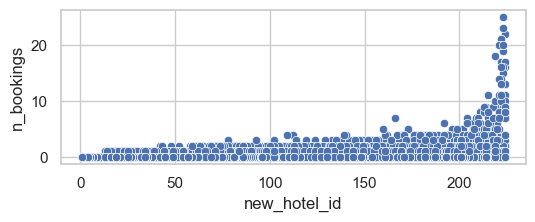

In [27]:
# Setting new hotel IDs, a higher n_booking value will correspond to a higher ID

hotels_total_booking = df_merged.groupby(['hotel_id'])[['n_bookings']].sum().sort_values('n_bookings').reset_index()

mapping = {value: index + 1 for index, value in enumerate(hotels_total_booking['hotel_id'])}

df_merged['new_hotel_id'] = df_merged['hotel_id'].map(mapping)

sns.scatterplot(data=df_merged, x='new_hotel_id', y='n_bookings');

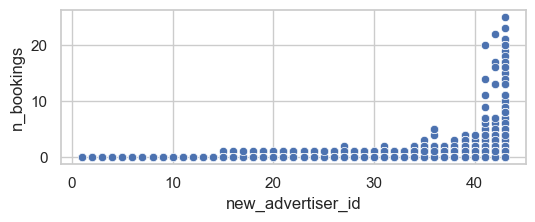

In [28]:
# Setting new advertiser IDs, a higher n_booking value will correspond to a higher ID

advertiers_total_booking = df_merged.groupby(['advertiser_id'])[['n_bookings']].sum().sort_values('n_bookings').reset_index()

mapping = {value: index + 1 for index, value in enumerate(advertiers_total_booking['advertiser_id'])}

df_merged['new_advertiser_id'] = df_merged['advertiser_id'].map(mapping)

sns.scatterplot(data=df_merged, x='new_advertiser_id', y='n_bookings');

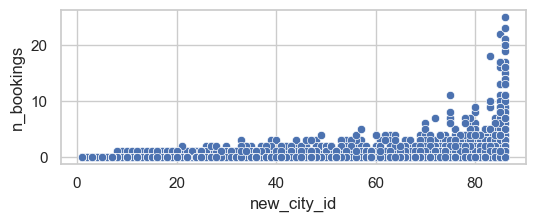

In [29]:
# Setting new city IDs, a higher n_booking value will correspond to a higher ID

cities_total_booking = df_merged.groupby(['city_id'])[['n_bookings']].sum().sort_values('n_bookings').reset_index()

mapping = {value: index + 1 for index, value in enumerate(cities_total_booking['city_id'])}

df_merged['new_city_id'] = df_merged['city_id'].map(mapping)

sns.scatterplot(data=df_merged, x='new_city_id', y='n_bookings');

Let's deal now with the right-skewed distribution of the n_reviews feature by applying some transformation.

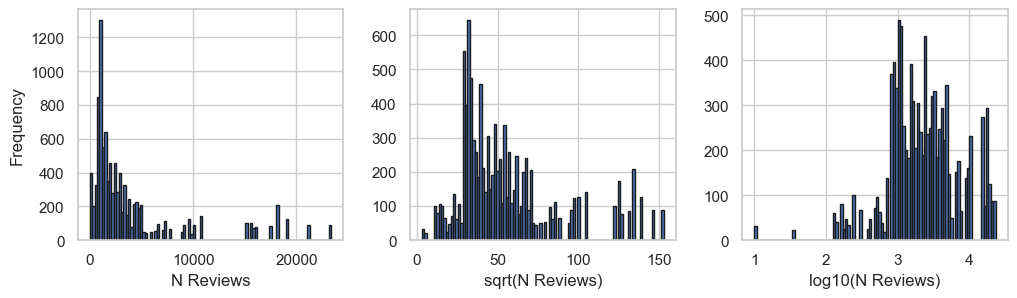

In [30]:
fig7, ax = plt.subplots(1, 3, figsize = (12,3))
plt.subplots_adjust(wspace=0.25)

bins = int(np.sqrt(len(df_merged)))

ax[0].hist(df_merged['n_reviews'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0].set(xlabel='N Reviews', ylabel='Frequency')

ax[1].hist(np.sqrt(df_merged['n_reviews']), bins=bins, color='C0', edgecolor='k', zorder=2)
ax[1].set(xlabel='sqrt(N Reviews)', ylabel='')

ax[2].hist(np.log10(df_merged['n_reviews']), bins=bins, color='C0', edgecolor='k', zorder=2)
ax[2].set(xlabel='log10(N Reviews)', ylabel='')

plt.show()

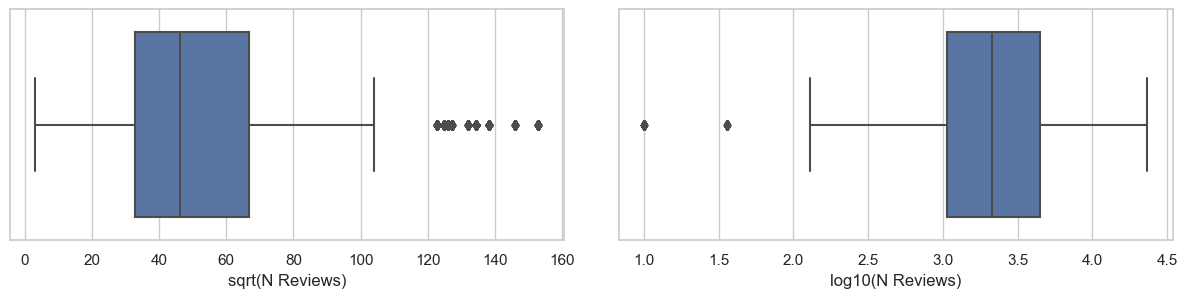

In [31]:
fig8, ax = plt.subplots(1, 2, figsize = (15,3))
plt.subplots_adjust(wspace=0.1)

sns.boxplot(np.sqrt(df_merged['n_reviews']), orient='h', ax=ax[0])
ax[0].set(xlabel='sqrt(N Reviews)', ylabel='')

sns.boxplot(np.log10(df_merged['n_reviews']), orient='h', ax=ax[1])
ax[1].set(xlabel='log10(N Reviews)', ylabel='')

for x in range(2):
    ax[x].set_yticks([])
    ax[x].set_yticklabels([])

plt.show()

The log10 transformation led to the best results. Let's deal with the remaning outliers by setting a lower-limit.

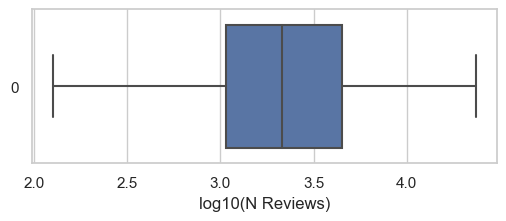

In [32]:
# Dealing with outliers in n_reviews, by log10 transformation and cutoff to interquartile ranges

df_merged['log10_reviews'] = round(np.log10(df_merged['n_reviews']), 4)

df_merged.loc[df_merged['log10_reviews'] < outliers(df_merged['log10_reviews'])[0], 'log10_reviews'] = outliers(df_merged['log10_reviews'])[0]

sns.boxplot(df_merged['log10_reviews'], orient='h')
plt.xlabel('log10(N Reviews)');

Let's check how the different features correlate to the n_bookings and n_clickouts features.

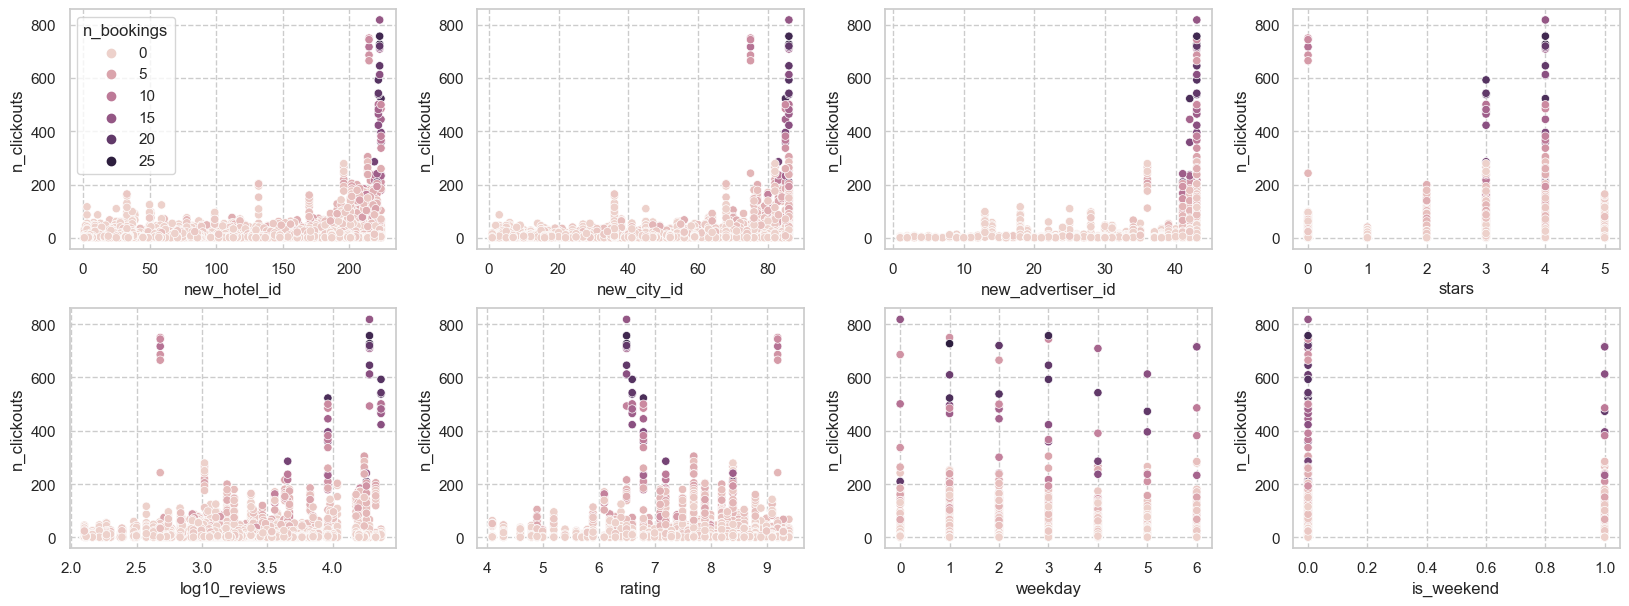

In [33]:
fig9, ax = plt.subplots(2, 4, figsize = (20,7))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

sns.scatterplot(data=df_merged, x='new_hotel_id', y='n_clickouts', hue='n_bookings', ax=ax[0,0])
sns.scatterplot(data=df_merged, x='new_city_id', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[0,1])
sns.scatterplot(data=df_merged, x='new_advertiser_id', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[0,2])
sns.scatterplot(data=df_merged, x='stars', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[0,3])
sns.scatterplot(data=df_merged, x='log10_reviews', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,0])
sns.scatterplot(data=df_merged, x='rating', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,1])
sns.scatterplot(data=df_merged, x='weekday', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,2])
sns.scatterplot(data=df_merged, x='is_weekend', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,3])

for x in range(2):
    for y in range(4):
        ax[x,y].grid(ls='--', zorder=0)

plt.show()

1. We note that the number of bookings is higher than ~5 when the number of clickouts goes above ~200.
2. We note a clear trend for the hotel_id, city_id, and advertser_id. As previously seen, some hotels, cities, and advertiser have more clickouts and bookings.
3. We do not note a clear trend of the target features with the weekday and is_weekend features.
4. We note some clear outliers with the overall trend in the stars, reviews, and rating features.

In [34]:
# Checking outliers

df_merged[(df_merged['stars'] == 0) & (df_merged['n_clickouts'] > 600)]

,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id,date,day,weekday,is_weekend,new_hotel_id,new_advertiser_id,new_city_id,log10_reviews
6107,214,5,717,11,0,479.0,9.2,27,2023-08-06,6,6,1,215,43,75,2.6803
7142,214,5,686,7,0,479.0,9.2,27,2023-08-07,7,0,0,215,43,75,2.6803
8186,214,5,750,7,0,479.0,9.2,27,2023-08-08,8,1,0,215,43,75,2.6803
9235,214,5,665,6,0,479.0,9.2,27,2023-08-09,9,2,0,215,43,75,2.6803
10257,214,5,744,8,0,479.0,9.2,27,2023-08-10,10,3,0,215,43,75,2.6803


In [35]:
df_merged[(df_merged['hotel_id'] == 214) & (df_merged['advertiser_id'] == 5)][['date', 'hotel_id', 'advertiser_id', 'n_clickouts', 'n_bookings', 'stars', 'n_reviews', 'rating', 'city_id']]

,date,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id
999,2023-08-01,214,5,1,0,0,479.0,9.2,27
2066,2023-08-02,214,5,3,2,0,479.0,9.2,27
3082,2023-08-03,214,5,17,0,0,479.0,9.2,27
4103,2023-08-04,214,5,52,1,0,479.0,9.2,27
5113,2023-08-05,214,5,243,3,0,479.0,9.2,27
6107,2023-08-06,214,5,717,11,0,479.0,9.2,27
7142,2023-08-07,214,5,686,7,0,479.0,9.2,27
8186,2023-08-08,214,5,750,7,0,479.0,9.2,27
9235,2023-08-09,214,5,665,6,0,479.0,9.2,27
10257,2023-08-10,214,5,744,8,0,479.0,9.2,27


We note a strong increase in clickouts and bookings for the hotel 214 - advertiser 5 couple starting from 2023-08-05.
Maybe a new advertisement campaign?

To help the training of the model I decided to imput the outliers values to fit the overall trend.

In [36]:
# Inputing values to outliers

df_merged.loc[df_merged['hotel_id'] == 214, 'stars'] = df_merged[df_merged['n_clickouts'] > 600]['stars'].max()
df_merged.loc[df_merged['hotel_id'] == 214, 'log10_reviews'] = df_merged[df_merged['n_clickouts'] > 600]['log10_reviews'].max()
df_merged.loc[df_merged['hotel_id'] == 214, 'rating'] = df_merged[df_merged['n_clickouts'] > 600]['rating'].min()

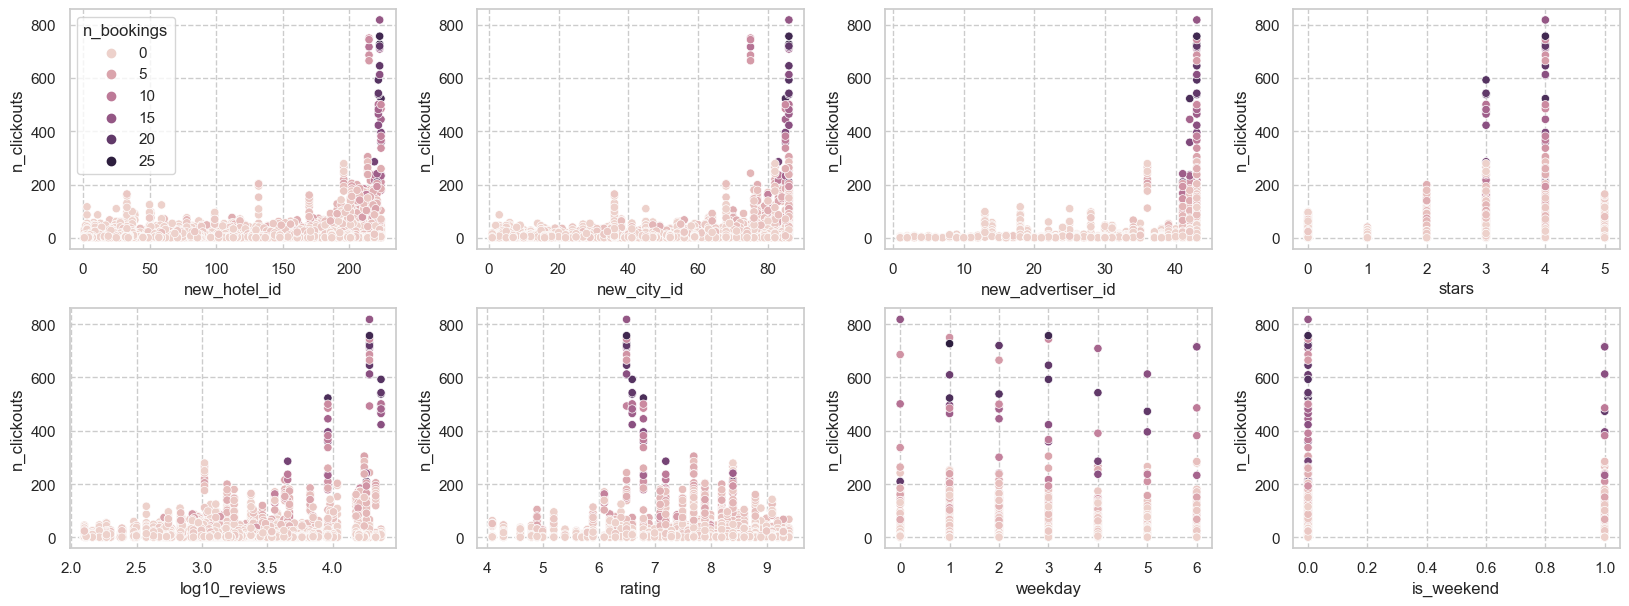

In [37]:
fig10, ax = plt.subplots(2, 4, figsize = (20,7))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

sns.scatterplot(data=df_merged, x='new_hotel_id', y='n_clickouts', hue='n_bookings', ax=ax[0,0])
sns.scatterplot(data=df_merged, x='new_city_id', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[0,1])
sns.scatterplot(data=df_merged, x='new_advertiser_id', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[0,2])
sns.scatterplot(data=df_merged, x='stars', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[0,3])
sns.scatterplot(data=df_merged, x='log10_reviews', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,0])
sns.scatterplot(data=df_merged, x='rating', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,1])
sns.scatterplot(data=df_merged, x='weekday', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,2])
sns.scatterplot(data=df_merged, x='is_weekend', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,3])

for x in range(2):
    for y in range(4):
        ax[x,y].grid(ls='--', zorder=0)

plt.show()
#fig10.savefig('EDA.jpg', dpi=250, bbox_inches='tight')

Let's get some insights from the data.

In [38]:
# Top 5 hotels for number of bookings

df_merged.groupby(['hotel_id'])[['n_clickouts','n_bookings']].sum().reset_index().sort_values('n_bookings', ascending=False).head(5)

,hotel_id,n_clickouts,n_bookings
72,73,6451,205
35,36,7910,195
25,26,5560,177
32,33,2999,118
34,35,3419,101


In [39]:
# Top 5 hotels for number of clickouts

df_merged.groupby(['hotel_id'])[['n_clickouts','n_bookings']].sum().reset_index().sort_values('n_clickouts', ascending=False).head(5)

,hotel_id,n_clickouts,n_bookings
35,36,7910,195
72,73,6451,205
25,26,5560,177
213,214,4058,52
34,35,3419,101


In [40]:
# Top 5 cities for number of bookings

df_merged.groupby(['city_id'])[['n_clickouts','n_bookings']].sum().reset_index().sort_values('n_bookings', ascending=False).head(5)

,city_id,n_clickouts,n_bookings
33,34,46099,1157
2,3,11632,364
50,51,5383,159
66,67,2734,159
45,46,8148,154


In [41]:
# Top 5 cities for number of clickouts

df_merged.groupby(['city_id'])[['n_clickouts','n_bookings']].sum().reset_index().sort_values('n_clickouts', ascending=False).head(5)

,city_id,n_clickouts,n_bookings
33,34,46099,1157
2,3,11632,364
45,46,8148,154
50,51,5383,159
26,27,4058,52


In [42]:
# Top 5 advertiser for number of bookings

df_merged.groupby(['advertiser_id'])[['n_clickouts','n_bookings']].sum().reset_index().sort_values('n_bookings', ascending=False).head(5)

,advertiser_id,n_clickouts,n_bookings
4,5,77406,1858
38,39,22256,588
36,37,13383,543
23,24,4819,150
0,1,3557,129


In [43]:
# Top 5 advertiser for number of clickouts

df_merged.groupby(['advertiser_id'])[['n_clickouts','n_bookings']].sum().reset_index().sort_values('n_clickouts', ascending=False).head(5)

,advertiser_id,n_clickouts,n_bookings
4,5,77406,1858
38,39,22256,588
36,37,13383,543
23,24,4819,150
0,1,3557,129


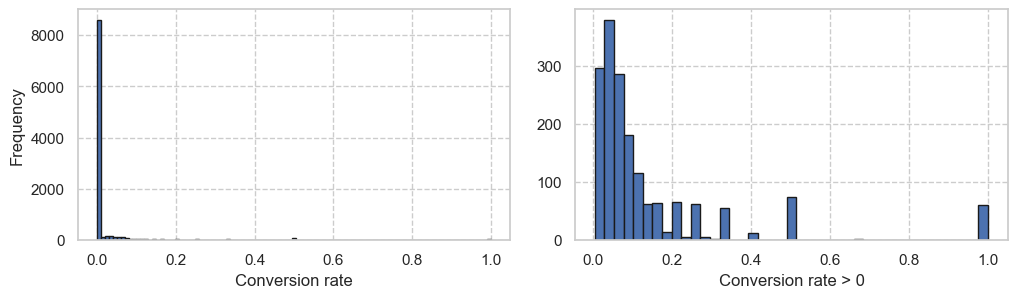

In [44]:
# Creating the conversion rate column

df_merged['conversion_rate'] = df_merged['n_bookings']/df_merged['n_clickouts']

fig11, ax = plt.subplots(1, 2, figsize = (12,3))
plt.subplots_adjust(wspace=0.15)

bins = int(np.sqrt(len(df_merged)))

ax[0].hist(df_merged['conversion_rate'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0].grid(ls='--', zorder=0)
ax[0].set(xlabel='Conversion rate', ylabel='Frequency')

bins = int(np.sqrt(len(df_merged[df_merged['conversion_rate'] > 0])))

ax[1].hist(df_merged[df_merged['conversion_rate'] > 0]['conversion_rate'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[1].grid(ls='--', zorder=0)
ax[1].set(xlabel='Conversion rate > 0', ylabel='')

plt.show()

As the n_bookings and n_clickouts features are right-skewed, so is the distribution of their ratio. Let's check if some transformation can help reduce the skeweness.

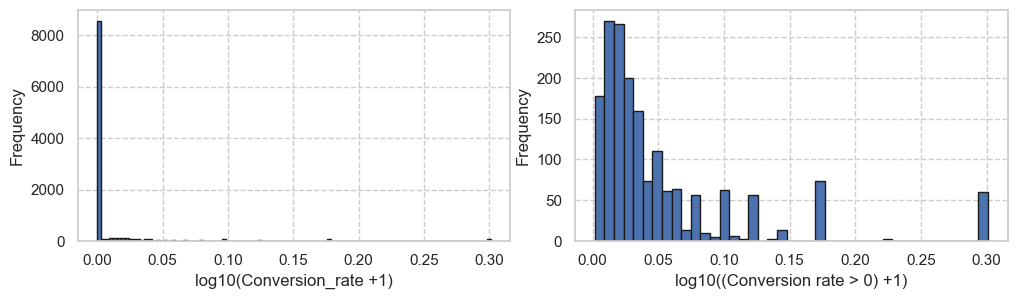

In [45]:
# log10 +1 transformation of the conversion rate column

df_merged['log10+1_conversion_rate'] = np.log10(df_merged['conversion_rate'] +1)

fig12, ax = plt.subplots(1, 2, figsize = (12,3))
plt.subplots_adjust(wspace=0.15)

bins = int(np.sqrt(len(df_merged)))

ax[0].hist(df_merged['log10+1_conversion_rate'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0].grid(ls='--', zorder=0)
ax[0].set(xlabel='log10(Conversion_rate +1)', ylabel='Frequency')

bins = int(np.sqrt(len(df_merged[df_merged['log10+1_conversion_rate'] > 0])))

ax[1].hist(df_merged[df_merged['log10+1_conversion_rate'] > 0]['log10+1_conversion_rate'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[1].grid(ls='--', zorder=0)
ax[1].set(xlabel='log10((Conversion rate > 0) +1)', ylabel='Frequency')

plt.show()

The log10 transformation did not work. Let's try a boxcox transformation.

In [46]:
df_merged.drop('log10+1_conversion_rate', axis=1, inplace=True)

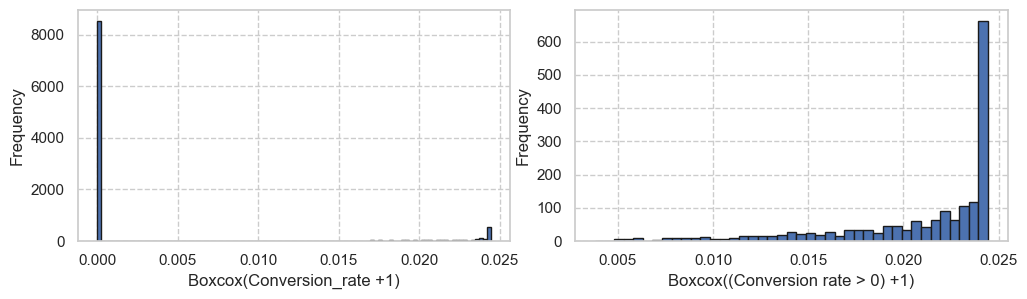

In [47]:
# Boxcox +1 transformation of the conversion rate column

df_merged['conversion_rate_boxcox'], lambda_value_cr = boxcox(df_merged['conversion_rate'] +1)

fig13, ax = plt.subplots(1, 2, figsize = (12,3))
plt.subplots_adjust(wspace=0.15)

bins = int(np.sqrt(len(df_merged)))

ax[0].hist(df_merged['conversion_rate_boxcox'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[0].grid(ls='--', zorder=0)
ax[0].set(xlabel='Boxcox(Conversion_rate +1)', ylabel='Frequency')

bins = int(np.sqrt(len(df_merged[df_merged['conversion_rate_boxcox'] > 0])))

ax[1].hist(df_merged[df_merged['conversion_rate_boxcox'] > 0]['conversion_rate_boxcox'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax[1].grid(ls='--', zorder=0)
ax[1].set(xlabel='Boxcox((Conversion rate > 0) +1)', ylabel='Frequency')

plt.show()

The situation got worse. We need to find a different strategy.

In [48]:
df_merged.drop('conversion_rate_boxcox', axis=1, inplace=True)

Let's create some additional features that may help the training of our model. Maybe the future value of the convertion rate depends on its past values. For this reason, I create lagged features.

In [49]:
# Creating lagged conversion rate columns

df_merged = df_merged.sort_values(by='date')

df_merged['conversion_rate_lag1'] = df_merged.groupby(['hotel_id', 'advertiser_id'])['conversion_rate'].shift(1)

df_merged['conversion_rate_lag1'].fillna(0, inplace=True)

df_merged['conversion_rate_lag2'] = df_merged.groupby(['hotel_id', 'advertiser_id'])['conversion_rate'].shift(2)

df_merged['conversion_rate_lag2'].fillna(0, inplace=True)

# Creating difference between conversion rate lagged 1 and conversion rate lagged 2

df_merged['conversion_rate_var'] = df_merged['conversion_rate_lag1'] - df_merged['conversion_rate_lag2']

# Creating lagged n_bookings

df_merged['bookings_lag1'] = df_merged.groupby(['hotel_id', 'advertiser_id'])['n_bookings'].shift(1)
df_merged['bookings_lag1'].fillna(0, inplace=True)

# Creating lagged n_clickouts

df_merged['clickouts_lag1'] = df_merged.groupby(['hotel_id', 'advertiser_id'])['n_clickouts'].shift(1)
df_merged['clickouts_lag1'].fillna(0, inplace=True)

df_merged[df_merged['new_hotel_id'] == 215].head(5)

,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id,date,day,...,new_hotel_id,new_advertiser_id,new_city_id,log10_reviews,conversion_rate,conversion_rate_lag1,conversion_rate_lag2,conversion_rate_var,bookings_lag1,clickouts_lag1
999,214,5,1,0,4,479.0,6.5,27,2023-08-01,1,...,215,43,75,4.2808,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2066,214,5,3,2,4,479.0,6.5,27,2023-08-02,2,...,215,43,75,4.2808,0.666667,0.000000,0.000000,0.000000,0.0,1.0
3082,214,5,17,0,4,479.0,6.5,27,2023-08-03,3,...,215,43,75,4.2808,0.000000,0.666667,0.000000,0.666667,2.0,3.0
4102,214,1,1,0,4,479.0,6.5,27,2023-08-04,4,...,215,39,75,4.2808,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4103,214,5,52,1,4,479.0,6.5,27,2023-08-04,4,...,215,43,75,4.2808,0.019231,0.000000,0.666667,-0.666667,0.0,17.0


<a id='str1'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Strategy 1. Regression Model <span style="float:right;"> 3 </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

Let's try to train the model on the data as they are.

In [50]:
# Train - Test split

df_train = df_merged[df_merged.date < '2023-08-09']
df_test = df_merged[df_merged.date >= '2023-08-09']

print('Portion of the whole dataset saved as test subset:', round(len(df_test)/len(df_merged)*100, 2), '%')

Portion of the whole dataset saved as test subset: 20.11 %


In [51]:
df_train.columns

Index(['hotel_id', 'advertiser_id', 'n_clickouts', 'n_bookings', 'stars',
       'n_reviews', 'rating', 'city_id', 'date', 'day', 'weekday',
       'is_weekend', 'new_hotel_id', 'new_advertiser_id', 'new_city_id',
       'log10_reviews', 'conversion_rate', 'conversion_rate_lag1',
       'conversion_rate_lag2', 'conversion_rate_var', 'bookings_lag1',
       'clickouts_lag1'],
      dtype='object')

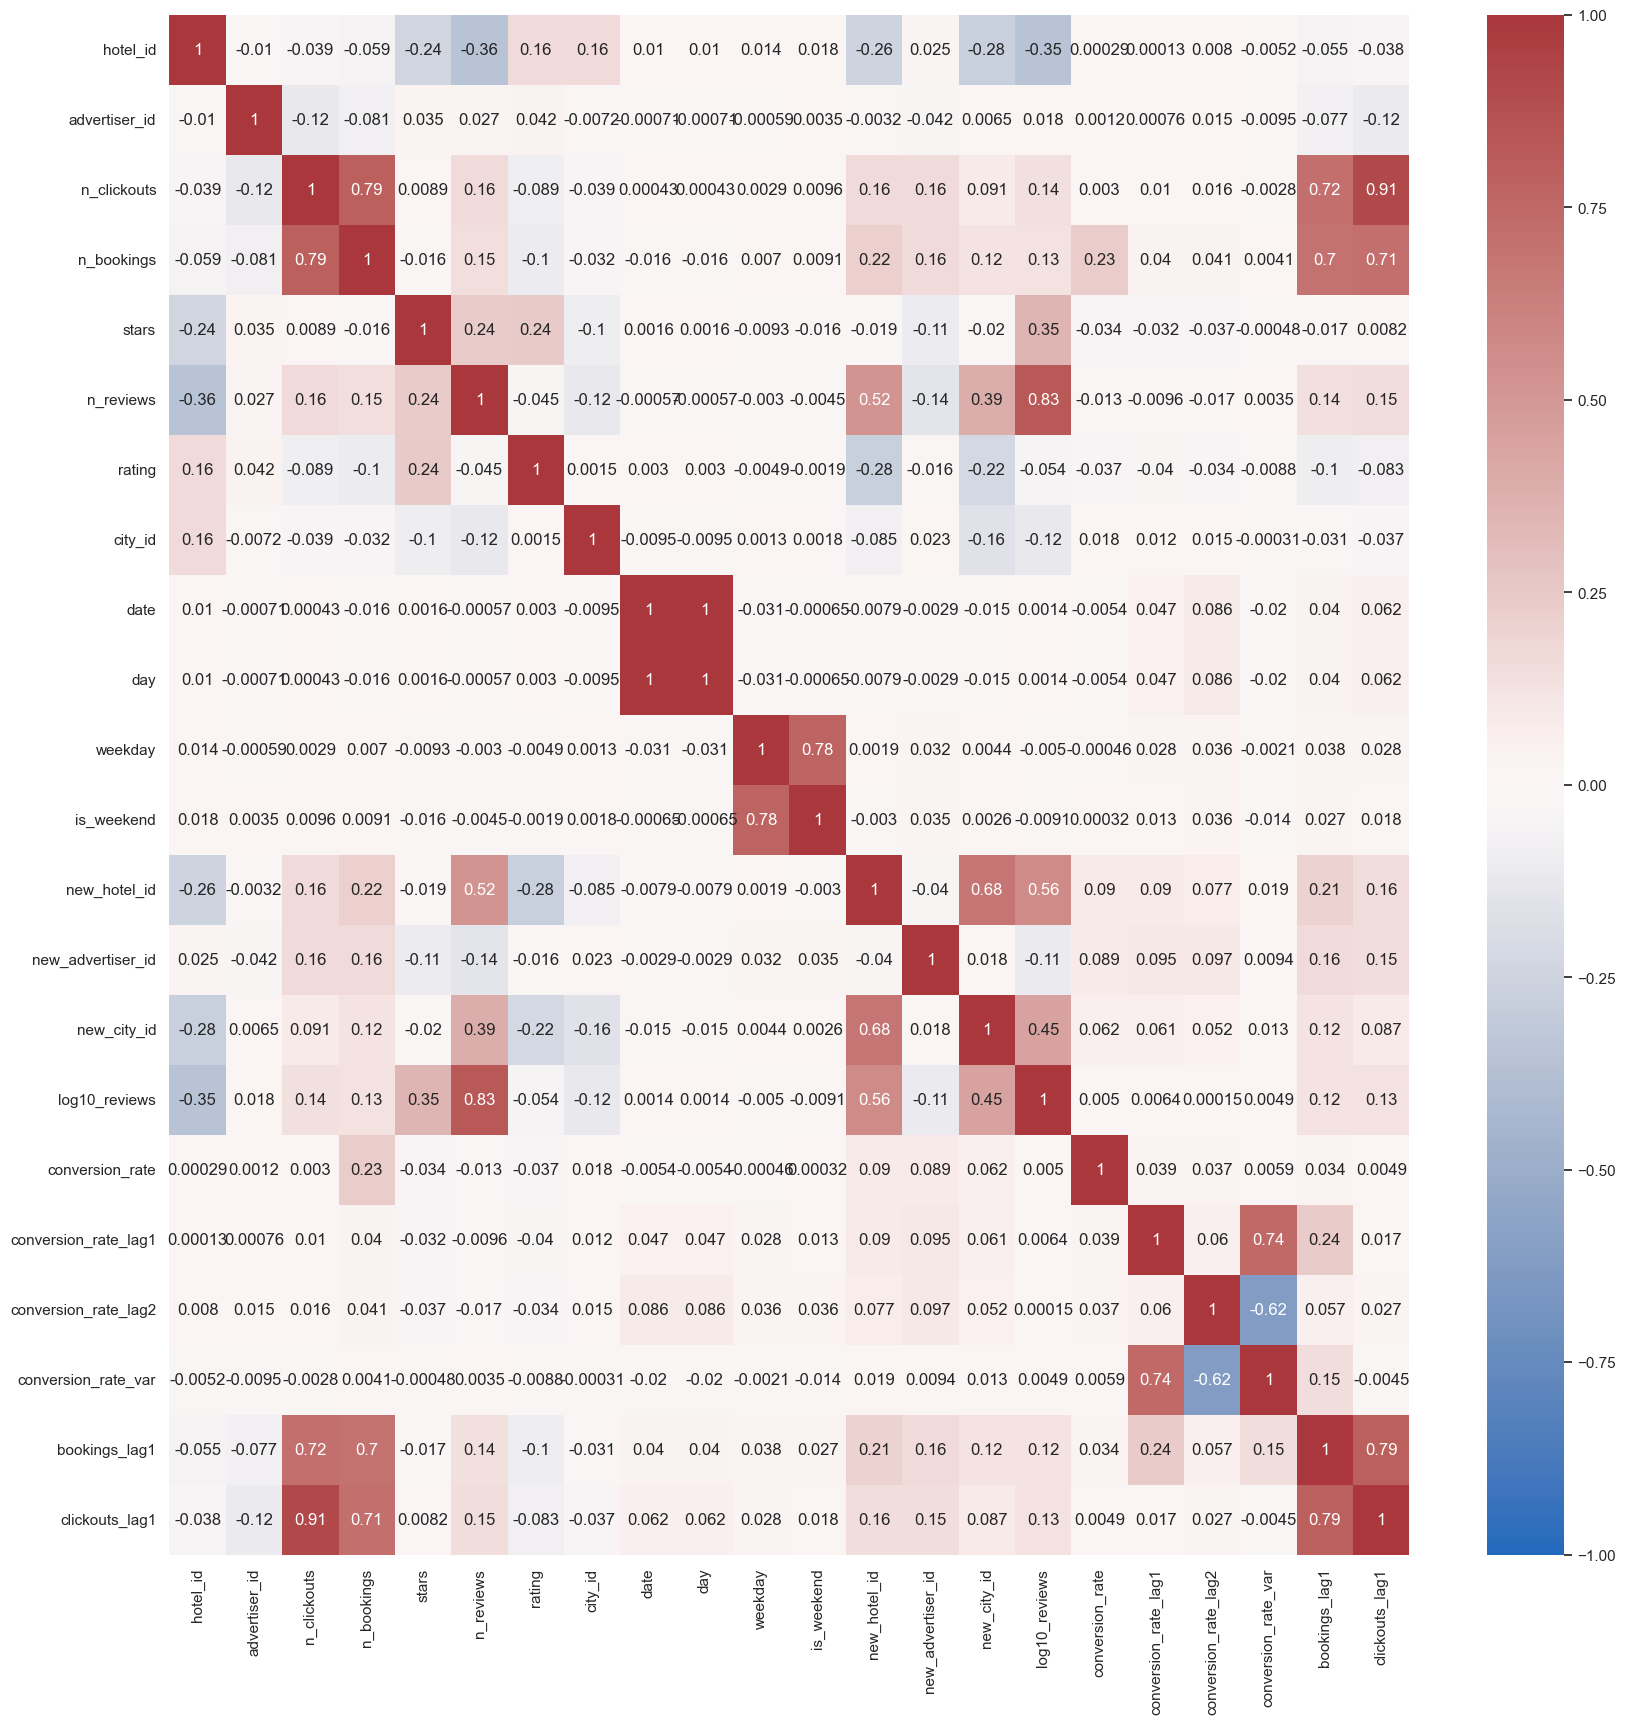

In [52]:
fig14, ax = plt.subplots(figsize = (20,20))

heatmap = sns.heatmap(df_merged.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))

plt.show()

We note different degrees of correlation between the predictors. 

1. As we saw earlier the is a strong positive correlation between the number of clickouts and bookings.
2. The number of bookings is correlated to its past values. Additionally, it is positively correlated with the new_hotel_id, the new_advertiser_id, the new_city_id, and the number of reviews. Similar correlation are shared with the number of clickouts.
3. The conversion rate has slightly positive correlation only with the new_hotel_id, the new_advertiser_id, and the new_city_id. Of course, the rate is positively correlated with the number of bookings, but the latter cannot be used as predictor or data leakage will be introduced.

In [53]:
# Selecting features

y_train = df_train['conversion_rate']
y_test = df_test['conversion_rate']

predictors = ['new_hotel_id', 'new_advertiser_id', 'new_city_id', 'stars', 'log10_reviews', 'rating', 'day', 
              'weekday', 'is_weekend', 'conversion_rate_lag1', 'conversion_rate_lag2', 'bookings_lag1',
              'clickouts_lag1']

X_train = df_train[predictors]
X_test = df_test[predictors]

R2 Score on Test Set:  0.0258


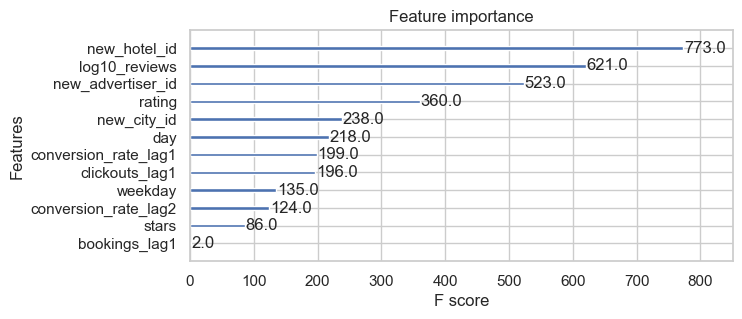

In [54]:
# XGBoost model creation and fit

xgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators=500, max_depth=3, 
                             reg_alpha=0.6, reg_lambda=0.0, random_state=0)

xgb_model.fit(X_train,y_train)

# Prediction and evaluation

y_pred = xgb_model.predict(X_test)
residuals = y_test - y_pred

r2 = round(r2_score(y_test, y_pred), 4)
print("R2 Score on Test Set: ", r2)

# Features importance

fig15, ax = plt.subplots(figsize = (7,3))
xgb.plot_importance(xgb_model, importance_type='weight', ax=ax)
plt.show()

After testing different values of the hyperparameters, the best $R^2$ score is equal to 0.026, meaning that the model can explain 2.6% of the target variable variance. The model therefore does not perform significantly better than a horizontal line fitting the data (a model that simply predicts the mean of the target variable). Removing some predictors in the training phase does not improve the situation. A different approach is needed.

<a id='str2'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Strategy 2. Classification + Regression <span style="float:right;"> 4 </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

The following approach consists of two steps. 

In the first step we are going to redifine the conversion rate as a binary variable, 0 in case the conversion rate is equal to zero, and 1 when the conversion rate is higher than zero. We will train a classification model to predict this binary target variable. 

In the second step, we are going to take only the predictions which results to be 1, and train on the filtered dateset a regression model to predict with a higher precision the conversion rate.

<a id='str2_cl'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:75%; font-family:Arial; margin-top: 75px;'> Strategy 2. Step 1: Classification Model <span style="float:right;"> 4.1 </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In [55]:
# Creating binary conversion rate column

df_merged['conversion_rate_bin'] = df_merged['conversion_rate']

df_merged.loc[df_merged['conversion_rate_bin'] > 0, 'conversion_rate_bin'] = 1

In [56]:
df_merged['conversion_rate_bin'].value_counts()

conversion_rate_bin
0.0    8543
1.0    1749
Name: count, dtype: int64

In [57]:
# Creating lagged conversion rate bin columns

df_merged['conversion_rate_bin_lag1'] = df_merged.groupby(['hotel_id', 'advertiser_id'])['conversion_rate_bin'].shift(1)

df_merged['conversion_rate_bin_lag1'].fillna(0, inplace=True)

df_merged['conversion_rate_bin_lag2'] = df_merged.groupby(['hotel_id', 'advertiser_id'])['conversion_rate_bin'].shift(2)

df_merged['conversion_rate_bin_lag2'].fillna(0, inplace=True)

# Creating difference between conversion rate lagged 1 and conversion rate lagged 2

df_merged['conversion_rate_bin_var'] = df_merged['conversion_rate_bin_lag1'] - df_merged['conversion_rate_bin_lag2']

df_merged[df_merged['new_hotel_id'] == 215].head(5)

,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id,date,day,...,conversion_rate,conversion_rate_lag1,conversion_rate_lag2,conversion_rate_var,bookings_lag1,clickouts_lag1,conversion_rate_bin,conversion_rate_bin_lag1,conversion_rate_bin_lag2,conversion_rate_bin_var
999,214,5,1,0,4,479.0,6.5,27,2023-08-01,1,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2066,214,5,3,2,4,479.0,6.5,27,2023-08-02,2,...,0.666667,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0
3082,214,5,17,0,4,479.0,6.5,27,2023-08-03,3,...,0.000000,0.666667,0.000000,0.666667,2.0,3.0,0.0,1.0,0.0,1.0
4102,214,1,1,0,4,479.0,6.5,27,2023-08-04,4,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4103,214,5,52,1,4,479.0,6.5,27,2023-08-04,4,...,0.019231,0.000000,0.666667,-0.666667,0.0,17.0,1.0,0.0,1.0,-1.0


In [58]:
# Train - Test split

df_train = df_merged[df_merged.date < '2023-08-09']
df_test = df_merged[df_merged.date >= '2023-08-09']

print('Portion of the whole dataset saved as test subset:', round(len(df_test)/len(df_merged)*100, 2), '%')

Portion of the whole dataset saved as test subset: 20.11 %


In [59]:
df_merged.columns

Index(['hotel_id', 'advertiser_id', 'n_clickouts', 'n_bookings', 'stars',
       'n_reviews', 'rating', 'city_id', 'date', 'day', 'weekday',
       'is_weekend', 'new_hotel_id', 'new_advertiser_id', 'new_city_id',
       'log10_reviews', 'conversion_rate', 'conversion_rate_lag1',
       'conversion_rate_lag2', 'conversion_rate_var', 'bookings_lag1',
       'clickouts_lag1', 'conversion_rate_bin', 'conversion_rate_bin_lag1',
       'conversion_rate_bin_lag2', 'conversion_rate_bin_var'],
      dtype='object')

In [60]:
# Selecting features

y_train = df_train['conversion_rate_bin']
y_test = df_test['conversion_rate_bin']

selected_features = ['new_hotel_id', 'new_advertiser_id', 'new_city_id', 'stars', 'log10_reviews', 'rating',
                     'is_weekend', 'day', 'weekday', 'conversion_rate_bin_lag1', 'conversion_rate_bin_lag2',
                     'conversion_rate_bin_var', 'bookings_lag1', 'clickouts_lag1']

X_train = df_train[selected_features]
X_test = df_test[selected_features]

In [61]:
# Naive-Bayes model creation and fit

model = GaussianNB()
model.fit(X_train, y_train)

# Prediction and evaluation

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
accuracy = round(accuracy_score(y_test, y_pred), 4)
auc_score = round(roc_auc_score(y_test, y_pred_proba), 4)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC Score:", auc_score)

Accuracy: 0.8043
Precision: 0.8499
Recall: 0.8043
AUC Score: 0.829


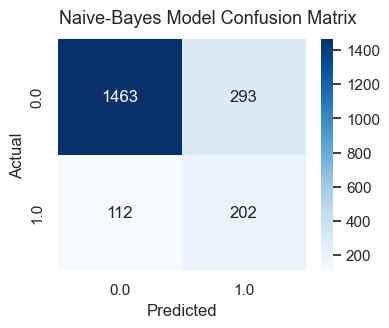

In [62]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig16, ax = plt.subplots(figsize = (4,3))

fig16.suptitle("Naive-Bayes Model Confusion Matrix", fontsize=13)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

The Naive-Bayes model was able to classify correctly 80.4% of our test entries. The model was able to classify correctly 83.3% of the null conversion rates targets, and 64.3% of the non-null conversion rates targets.

In [63]:
# Saving predictions

bayes_class_predictions_df = df_test[['date', 'hotel_id', 'advertiser_id', 'conversion_rate']].copy()

bayes_class_predictions_df['conversion_rate_predicted'] = y_pred

Let's try an XGBoost model.

Accuracy: 0.8768
Precision: 0.862
Recall: 0.8768
AUC Score: 0.8615


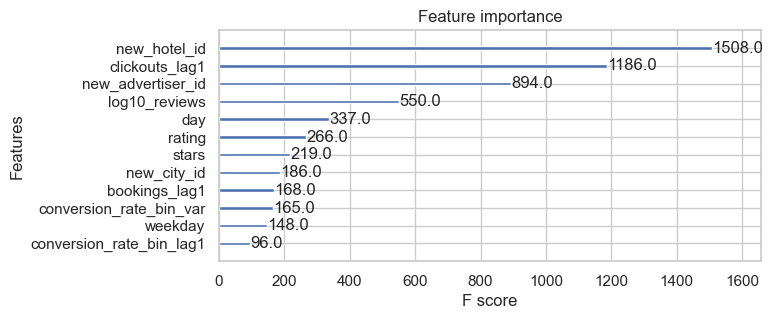

In [64]:
# XGBoost model creation and fit

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 0,
    'learning_rate': 0.01,
    'n_estimators': 200,
    'max_depth' : 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
    }

xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(X_train,y_train)

# Prediction and evaluation

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
accuracy = round(accuracy_score(y_test, y_pred), 4)
auc_score = round(roc_auc_score(y_test, y_pred_proba), 4)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC Score:", auc_score)

# Features importance

fig17, ax = plt.subplots(figsize = (7,3))
xgb.plot_importance(xgb_model, max_num_features=12, importance_type='weight', ax=ax)
plt.show()

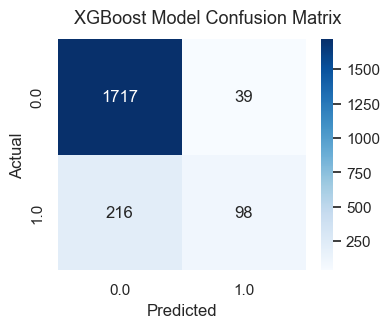

In [65]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig18, ax = plt.subplots(figsize = (4,3))

fig18.suptitle("XGBoost Model Confusion Matrix", fontsize=13)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

The XGBoost model performs better than the previous one, with an accuracy of 87.7%, an improvement of 7.3%.
The model was able to classify correctly 97.8% of the null conversion rates targets, but only 31.2% of the non-null conversion rates targets.

Let's try to reduce the number of predictors to improve the model explainability and let's check how the model metrics are impacted.

In [66]:
# Selecting features

y_train = df_train['conversion_rate_bin']
y_test = df_test['conversion_rate_bin']

selected_features = ['new_hotel_id', 'new_advertiser_id', 'new_city_id']

X_train = df_train[selected_features]
X_test = df_test[selected_features]

Precision: 0.8566
Recall: 0.8705
Accuracy: 0.8705
AUC Score: 0.8455


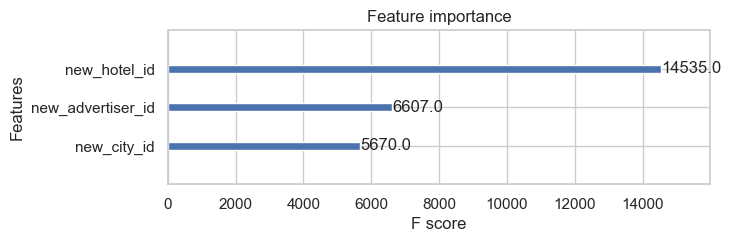

In [67]:
# Model creation

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 0,
    'learning_rate': 0.05,
    'n_estimators': 300,
    'max_depth' : 10,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
    }

xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(X_train,y_train)

# Model evaluation

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
accuracy = round(accuracy_score(y_test, y_pred), 4)
auc_score = round(roc_auc_score(y_test, y_pred_proba), 4)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("AUC Score:", auc_score)

# Features importance

fig19, ax = plt.subplots(figsize = (7,2))
xgb.plot_importance(xgb_model, max_num_features=12, importance_type='weight', ax=ax)
plt.show()
#fig19.savefig('BinaryPredictions_FI.jpg', dpi=250, bbox_inches='tight')

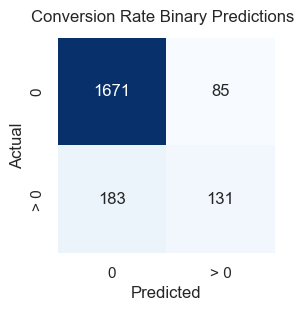

In [68]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig20, ax = plt.subplots(figsize = (2.8,2.8))

fig20.suptitle("Conversion Rate Binary Predictions", fontsize=12)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=['0', '> 0'], yticklabels=['0', '> 0'], cbar=False)

ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()
#fig20.savefig('BinaryPredictions.jpg', dpi=250, bbox_inches='tight')

By selecting only 'new_hotel_id', 'new_advertiser_id', and 'new_city_id' as predictors, the model accuracy decreased only by 0.65%, the model was able to classify correctly 95.2% of the null conversion rates targets, and 41.7% of the non-null conversion rates targets.

For simplicity we are going to use this last model for the rest of the project, but the Naive-Bayes model could be also tested.

In [69]:
# Saving predictions

xgboost_class_predictions_df = df_test[['date', 'hotel_id', 'advertiser_id', 'conversion_rate']].copy()

xgboost_class_predictions_df['conversion_rate_predicted'] = y_pred

<a id='str2_rg'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:75%; font-family:Arial; margin-top: 75px;'> Strategy 2. Step 2: Regression Model <span style="float:right;"> 4.2 </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

For time reasons I will continue the analysis only with the XGBoost classification model. Ideally, the Naive-Bayes classification model approach could be tested.

In [70]:
# Filtering the dataset to contain only the entries with a conversion rate predicted to be > 0

positive_prediction = xgboost_class_predictions_df[xgboost_class_predictions_df['conversion_rate_predicted'] == 1].groupby(['hotel_id', 'advertiser_id']).size().reset_index(name='count')

df_filtered = df_merged[df_merged.set_index(['hotel_id', 'advertiser_id']).index.isin(positive_prediction.set_index(['hotel_id', 'advertiser_id']).index)].copy()

df_filtered = df_filtered[df_filtered['conversion_rate_bin'] > 0]

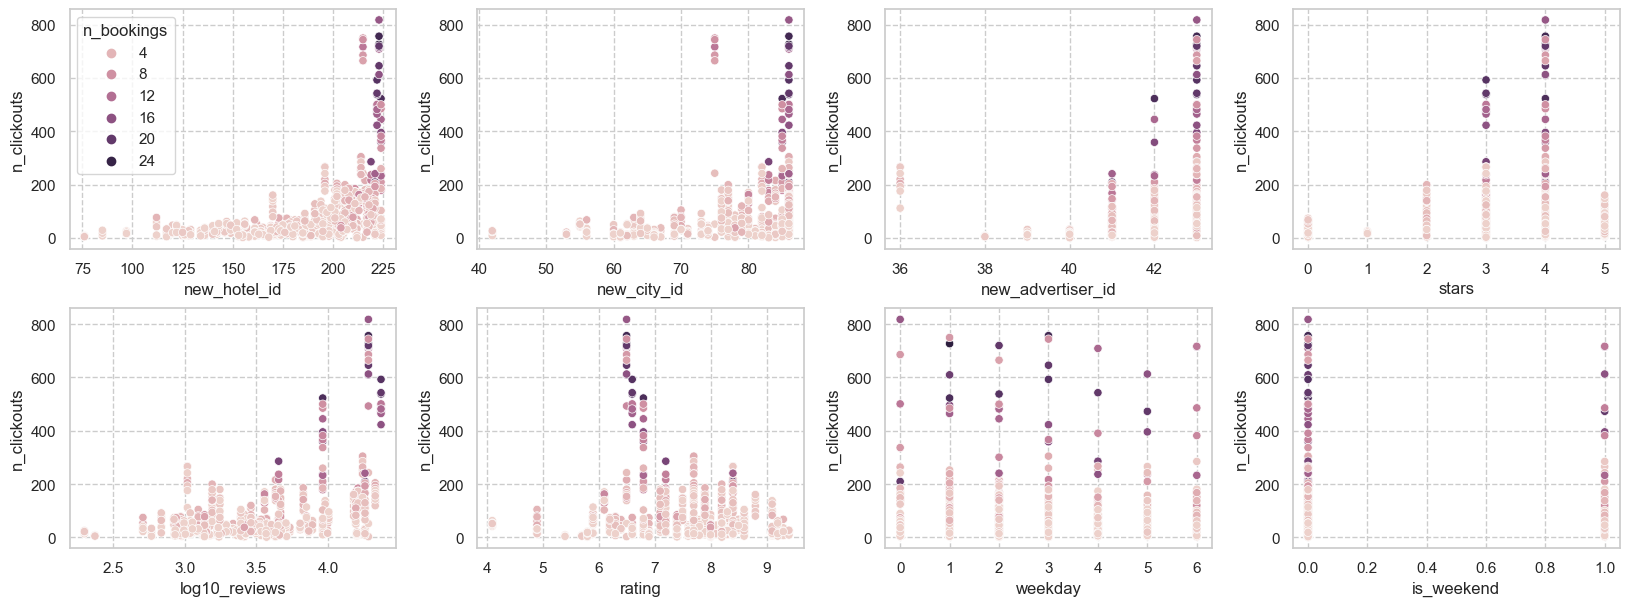

In [71]:
fig21, ax = plt.subplots(2, 4, figsize = (20,7))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

sns.scatterplot(data=df_filtered, x='new_hotel_id', y='n_clickouts', hue='n_bookings', ax=ax[0,0])
sns.scatterplot(data=df_filtered, x='new_city_id', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[0,1])
sns.scatterplot(data=df_filtered, x='new_advertiser_id', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[0,2])
sns.scatterplot(data=df_filtered, x='stars', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[0,3])
sns.scatterplot(data=df_filtered, x='log10_reviews', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,0])
sns.scatterplot(data=df_filtered, x='rating', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,1])
sns.scatterplot(data=df_filtered, x='weekday', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,2])
sns.scatterplot(data=df_filtered, x='is_weekend', y='n_clickouts', hue='n_bookings', legend=False, ax=ax[1,3])

for x in range(2):
    for y in range(4):
        ax[x,y].grid(ls='--', zorder=0)

plt.show()

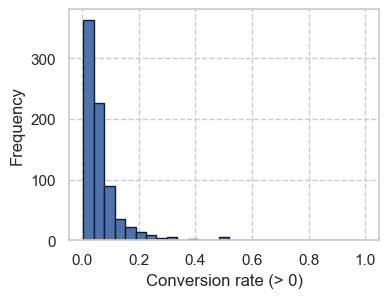

In [72]:
fig22, ax = plt.subplots(figsize = (4,3))

bins = int(np.sqrt(len(df_filtered)))

ax.hist(df_filtered['conversion_rate'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax.grid(ls='--', zorder=0)
ax.set(xlabel='Conversion rate (> 0)', ylabel='Frequency')

plt.show()

The conversion rate distribution is still right-skewed. Let's apply some transformation to change that.

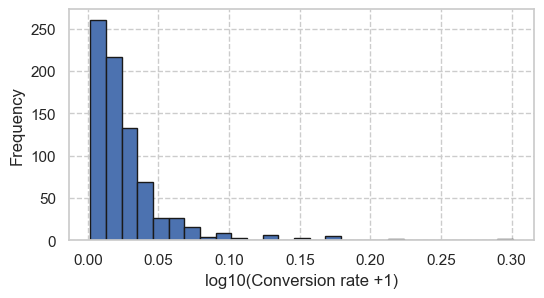

In [73]:
fig23, ax = plt.subplots(figsize = (6,3))

bins = int(np.sqrt(len(df_filtered)))

ax.hist(np.log10(df_filtered['conversion_rate'] +1), bins=bins, color='C0', edgecolor='k', zorder=2)
ax.grid(ls='--', zorder=0)
ax.set(xlabel='log10(Conversion rate +1)', ylabel='Frequency')

plt.show()

The log10 transformation did not work.

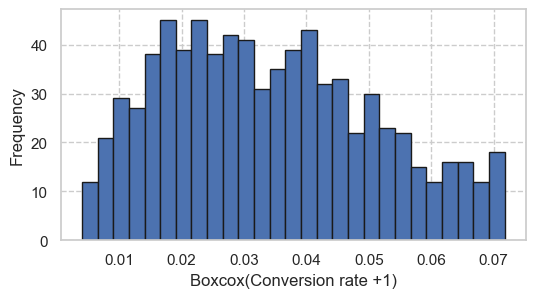

In [74]:
df_filtered['conversion_rate_boxcox'], lambda_value_cr = boxcox(df_filtered['conversion_rate'] +1)

fig24, ax = plt.subplots(figsize = (6,3))

bins = int(np.sqrt(len(df_filtered)))

ax.hist(df_filtered['conversion_rate_boxcox'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax.grid(ls='--', zorder=0)
ax.set(xlabel='Boxcox(Conversion rate +1)', ylabel='Frequency')

plt.show()

In [75]:
print(lambda_value_cr)

-13.936576271714262


Eventhough the boxcox transformation worked, the lambda value is negative, therefore we can't go back to the original values. Let's try the a yeo-johnson transformation.

In [76]:
df_filtered.drop('conversion_rate_boxcox', axis=1, inplace=True)

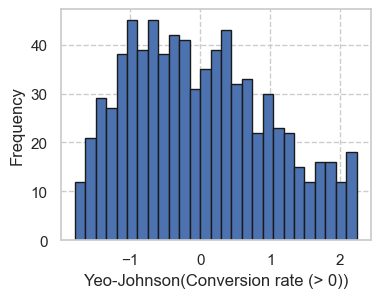

In [77]:
pt = PowerTransformer(method='yeo-johnson')
df_filtered['conversion_rate_yj'] = pt.fit_transform(df_filtered['conversion_rate'].values.reshape(-1, 1))

fig25, ax = plt.subplots(figsize = (4,3))

bins = int(np.sqrt(len(df_filtered)))

ax.hist(df_filtered['conversion_rate_yj'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax.grid(ls='--', zorder=0)
ax.set(xlabel='Yeo-Johnson(Conversion rate (> 0))', ylabel='Frequency')

plt.show()

The situation improved. We are going to use the yeo-johnson transformed values as our target variable.

In [78]:
# Creating lagged yj_conversion rate columns

df_filtered = df_filtered.sort_values(by='date')

df_filtered['yj_conversion_rate_lag1'] = df_filtered.groupby(['hotel_id', 'advertiser_id'])['conversion_rate_yj'].shift(1)

df_filtered['yj_conversion_rate_lag1'].fillna(0, inplace=True)

df_filtered['yj_conversion_rate_lag2'] = df_filtered.groupby(['hotel_id', 'advertiser_id'])['conversion_rate_yj'].shift(2)

df_filtered['yj_conversion_rate_lag2'].fillna(0, inplace=True)

# Creating difference between conversion rate lagged 1 and conversion rate lagged 2

df_filtered['yj_conversion_rate_var'] = df_filtered['yj_conversion_rate_lag1'] - df_filtered['yj_conversion_rate_lag2']

In [79]:
# Train - Test split

df_train = df_filtered[df_filtered.date < '2023-08-09']
df_test = df_filtered[df_filtered.date >= '2023-08-09']

print('Portion of the filtered dataset saved as test subset:', round(len(df_test)/len(df_filtered)*100, 2), '%')

Portion of the filtered dataset saved as test subset: 16.88 %


In [80]:
df_filtered.columns

Index(['hotel_id', 'advertiser_id', 'n_clickouts', 'n_bookings', 'stars',
       'n_reviews', 'rating', 'city_id', 'date', 'day', 'weekday',
       'is_weekend', 'new_hotel_id', 'new_advertiser_id', 'new_city_id',
       'log10_reviews', 'conversion_rate', 'conversion_rate_lag1',
       'conversion_rate_lag2', 'conversion_rate_var', 'bookings_lag1',
       'clickouts_lag1', 'conversion_rate_bin', 'conversion_rate_bin_lag1',
       'conversion_rate_bin_lag2', 'conversion_rate_bin_var',
       'conversion_rate_yj', 'yj_conversion_rate_lag1',
       'yj_conversion_rate_lag2', 'yj_conversion_rate_var'],
      dtype='object')

In [81]:
# Selecting features

y_train = df_train['conversion_rate_yj']
y_test = df_test['conversion_rate_yj']

predictors = ['new_hotel_id', 'new_advertiser_id', 'new_city_id', 'stars', 'log10_reviews', 'rating', 'day', 
              'weekday', 'is_weekend', 'bookings_lag1', 'clickouts_lag1', 
              'conversion_rate_lag1', 'conversion_rate_lag2', 'conversion_rate_var',]

X_train = df_train[predictors]
X_test = df_test[predictors]

R2 Score on Test Set:  0.4888


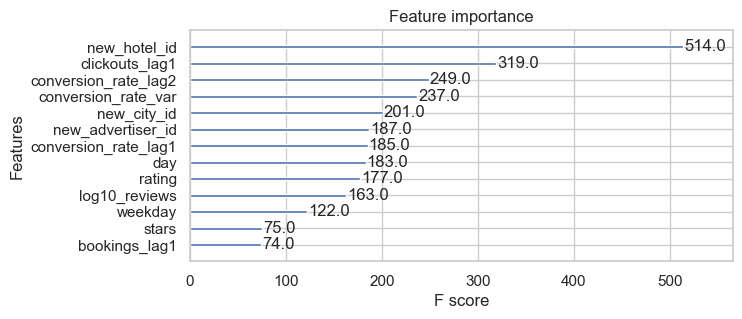

In [82]:
# Model creation and fit

xgb_model = xgb.XGBRegressor(learning_rate=0.05, n_estimators=100, max_depth=5, 
                             reg_alpha=0.0, reg_lambda=0.0, random_state=0)

xgb_model.fit(X_train,y_train)

# Model evaluation

y_pred = xgb_model.predict(X_test)

r2 = round(r2_score(y_test, y_pred), 4)
print("R2 Score on Test Set: ", r2)

# Features importance

fig26, ax = plt.subplots(figsize = (7,3))
xgb.plot_importance(xgb_model, importance_type='weight', ax=ax)
plt.show()

The regression model can explain 48.9% of the target variable variance. Let's try to improve the metric by selecting different sets of predictors. 

In [83]:
#y_train = df_train['conversion_rate_yj']
#y_test = df_test['conversion_rate_yj']
#
#predictors = ['new_hotel_id', 'new_advertiser_id', 'new_city_id', 'stars', 'log10_reviews', 'rating', 'day', 
#              'weekday', 'bookings_lag1', 'clickouts_lag1', 
#              'yj_conversion_rate_lag1', 'yj_conversion_rate_lag2', 'yj_conversion_rate_var']
#
#predictors_combination = generate_combinations(predictors)
#
#r2_list = []
#
#for combination in predictors_combination:
#
#    X_train = df_train[combination]
#    X_test = df_test[combination]
#
#    xgb_model = xgb.XGBRegressor(random_state=0)
#    xgb_model.fit(X_train,y_train)
#
#    y_pred = xgb_model.predict(X_test)
#
#    r2 = round(r2_score(y_test, y_pred), 4)
#    r2_list.append(r2)

Unfortunately, my laptop cannot handle the above cell, as the cores temperature reach values higher than 90 degree Celsius.

Therefore I tried manually some sets of predictors and the results of the best set follow.

In [84]:
# Selecting features

y_train = df_train['conversion_rate_yj']
y_test = df_test['conversion_rate_yj']

predictors = ['new_hotel_id', 'new_advertiser_id']

X_train = df_train[predictors]
X_test = df_test[predictors]

R2 Score on Test Set:  0.469


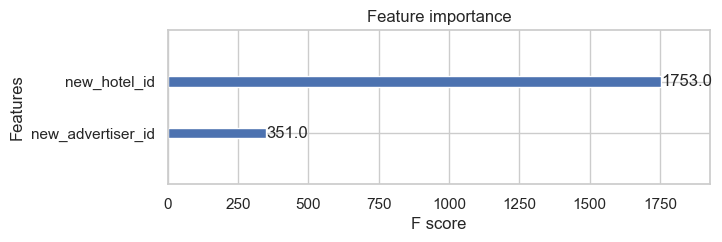

In [85]:
# Model creation and fit

xgb_model = xgb.XGBRegressor(learning_rate=0.06, n_estimators=100, max_depth=5, 
                             reg_alpha=0.0, reg_lambda=0.0, random_state=0)

xgb_model.fit(X_train,y_train)

# Model evaluation

y_pred = xgb_model.predict(X_test)

r2 = round(r2_score(y_test, y_pred), 4)
print("R2 Score on Test Set: ", r2)

# Features importance

fig27, ax = plt.subplots(figsize = (7,2))
xgb.plot_importance(xgb_model, importance_type='weight', ax=ax)
plt.show()
#fig27.savefig('Regressor_FI.jpg', dpi=250, bbox_inches='tight')

By selecting only 'new_hotel_id', 'new_advertiser_id' as predictors, the R2 score decreased only by 2%.
Even though this last model is worse in terms of R2 score, it take into accounts only two predictors while the previous model has 14. To preserve model explainability we sacrifice 2% on R2 score.

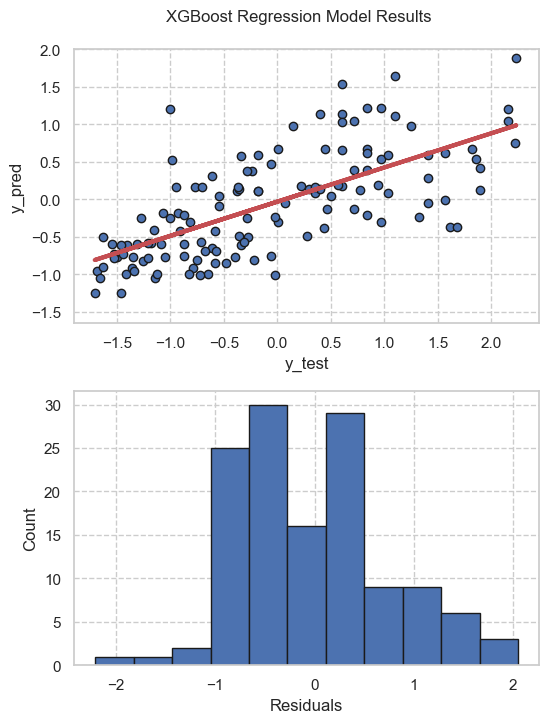

In [86]:
fig28, ax = plt.subplots(2, 1, figsize = (6,8))
plt.subplots_adjust(hspace=0.25)

coef = np.polyfit(y_test,y_pred,1)
poly1d_fn = np.poly1d(coef) 

fig28.suptitle("XGBoost Regression Model Results", fontsize=12, y=0.93)

ax[0].plot(y_test, y_pred, ls='none', marker='o', mec='k', zorder=2)
ax[0].plot(y_test, poly1d_fn(y_test), color='r', lw=3, zorder=3)
ax[0].grid(ls='--', zorder=0)
ax[0].set(xlabel='y_test', ylabel='y_pred')
ax[0].axis([-1.9,2.45,-1.65,2])

bins = int(np.sqrt(len(y_pred)))
residuals = y_test - y_pred

ax[1].hist(residuals, bins=bins, color='C0', edgecolor='k', zorder=2)
ax[1].grid(ls='--', zorder=0)
ax[1].set(xlabel='Residuals', ylabel='Count')

plt.show()
#fig28.savefig('RegressorResults.jpg', dpi=250, bbox_inches='tight')

The regression model does not capture very well the variance of the dataset. Nonetheless we see a linear trend between the predicted and actual values, eventhough with a large spread. The residuals distribution is fairly normal.

In [87]:
# Saving predictions

y_pred_true = pt.inverse_transform(y_pred.reshape(-1, 1))

y_pred_df = df_test[['date','hotel_id','advertiser_id']].copy()

y_pred_df['conversion_rate_predicted'] = y_pred_true

In [88]:
# Updating binary predictions with the regression predictions

xgboost_predictions_df = pd.merge(xgboost_class_predictions_df, y_pred_df, on=['date', 'hotel_id', 'advertiser_id'], how='left', suffixes=('_old', ''))

xgboost_predictions_df['conversion_rate_predicted'] = xgboost_predictions_df['conversion_rate_predicted'].fillna(xgboost_predictions_df['conversion_rate_predicted_old'])

xgboost_predictions_df = xgboost_predictions_df.drop('conversion_rate_predicted_old', axis=1)

xgboost_predictions_df['conversion_rate_predicted'] = round(xgboost_predictions_df['conversion_rate_predicted'], 6)

xgboost_predictions_df.head(7)

,date,hotel_id,advertiser_id,conversion_rate,conversion_rate_predicted
0,2023-08-09,3,39,0.000000,0.000000
1,2023-08-09,4,5,0.020000,0.039404
2,2023-08-09,4,1,0.000000,0.000000
3,2023-08-09,3,37,0.000000,0.000000
4,2023-08-09,1,37,0.000000,0.000000
5,2023-08-09,2,37,0.000000,0.000000
6,2023-08-09,2,5,0.047619,0.037774


<a id='forecast'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Final Model & Forecasting  <span style="float:right;"> 5 </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

Having tested our models, in this section I am going to train the models on the whole dataset and forecast the conversion rate for the 2023-08-11 day.

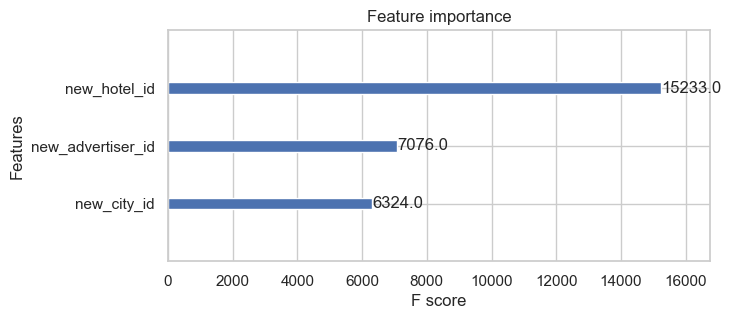

In [89]:
# Selecting features

y = df_merged['conversion_rate_bin']

selected_features = ['new_hotel_id', 'new_advertiser_id', 'new_city_id']

X = df_merged[selected_features]

# Classification model creation and fit

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 0,
    'learning_rate': 0.05,
    'n_estimators': 300,
    'max_depth' : 10,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
    }

xgb_model_classifier = xgb.XGBClassifier(**params)
xgb_model_classifier.fit(X,y)

# Features importance

fig29, ax = plt.subplots(figsize = (7,3))
xgb.plot_importance(xgb_model_classifier, importance_type='weight', ax=ax)
plt.show()

In [90]:
# Saving the model

#with open('1_conversion_rate_XGBoostClassifier.pkl', 'wb') as file:
#    pickle.dump(xgb_model_classifier, file)

In [91]:
# Creating forecasting dataframe

max_date = df_merged['date'].max()
new_date = max_date + dt.timedelta(days=1)

hotel_adv_combinations = df_merged[['hotel_id', 'advertiser_id', 'new_hotel_id', 'new_advertiser_id', 'new_city_id']].drop_duplicates()

predictions_dict = {'date': [new_date] * len(hotel_adv_combinations), 'hotel_id': [], 'advertiser_id': [], 'new_hotel_id': [], 'new_advertiser_id': [], 'new_city_id': []}

for index, row in hotel_adv_combinations.iterrows():
    predictions_dict['hotel_id'].append(row['hotel_id'])
    predictions_dict['advertiser_id'].append(row['advertiser_id'])
    predictions_dict['new_hotel_id'].append(row['new_hotel_id'])
    predictions_dict['new_advertiser_id'].append(row['new_advertiser_id'])
    predictions_dict['new_city_id'].append(row['new_city_id'])

predictions_df = pd.DataFrame(predictions_dict)

In [92]:
# Class Forecasting 

y_pred = xgb_model_classifier.predict(predictions_df[['new_hotel_id', 'new_advertiser_id', 'new_city_id']])

predictions_df['conversion_rate'] = y_pred

In [93]:
# Filtering the dataset to contain only the entries with a conversion rate predicted to be > 0

positive_prediction = predictions_df[predictions_df['conversion_rate'] == 1].groupby(['hotel_id', 'advertiser_id']).size().reset_index(name='count')

df_filtered = df_merged[df_merged.set_index(['hotel_id', 'advertiser_id']).index.isin(positive_prediction.set_index(['hotel_id', 'advertiser_id']).index)].copy()

df_filtered = df_filtered[df_filtered['conversion_rate_bin'] > 0]

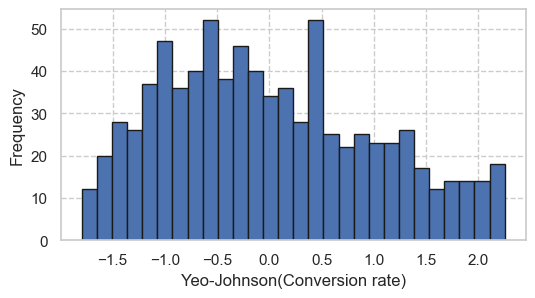

In [94]:
# Power transformation of the target variable

pt = PowerTransformer(method='yeo-johnson')
df_filtered['conversion_rate_yj'] = pt.fit_transform(df_filtered['conversion_rate'].values.reshape(-1, 1))

fig30, ax = plt.subplots(figsize = (6,3))

bins = int(np.sqrt(len(df_filtered)))

ax.hist(df_filtered['conversion_rate_yj'], bins=bins, color='C0', edgecolor='k', zorder=2)
ax.grid(ls='--', zorder=0)
ax.set(xlabel='Yeo-Johnson(Conversion rate)', ylabel='Frequency')

plt.show()

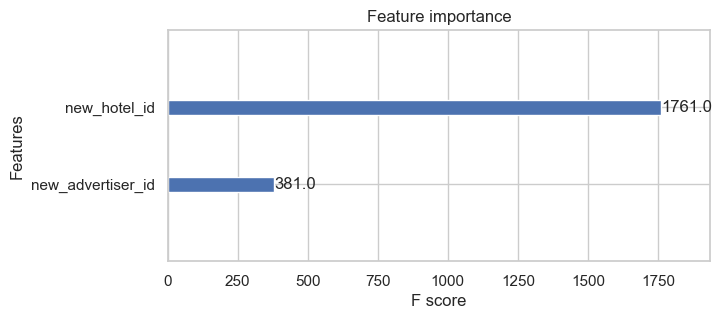

In [95]:
# Selecting features

y = df_filtered['conversion_rate_yj']

predictors = ['new_hotel_id', 'new_advertiser_id']

X = df_filtered[predictors]

# Regression model creation and fit

xgb_model_regressor = xgb.XGBRegressor(learning_rate=0.06, n_estimators=100, max_depth=5, 
                             reg_alpha=0.0, reg_lambda=0.0, random_state=0)

xgb_model_regressor.fit(X,y)

# Features importance

fig31, ax = plt.subplots(figsize = (7,3))
xgb.plot_importance(xgb_model_regressor, importance_type='weight', ax=ax)
plt.show()

In [96]:
# Saving the model

#with open('2_conversion_rate_XGBoostRegressor.pkl', 'wb') as file:
#    pickle.dump(xgb_model_regressor, file)

In [97]:
# Creating filtered forecasting dataframe

max_date = df_merged['date'].max()
new_date = max_date + dt.timedelta(days=1)

hotel_adv_combinations = df_filtered[['hotel_id', 'advertiser_id', 'new_hotel_id', 'new_advertiser_id']].drop_duplicates()

predictions_dict = {'date': [new_date] * len(hotel_adv_combinations), 'hotel_id': [], 'advertiser_id': [], 'new_hotel_id': [], 'new_advertiser_id': []}

for index, row in hotel_adv_combinations.iterrows():
    predictions_dict['hotel_id'].append(row['hotel_id'])
    predictions_dict['advertiser_id'].append(row['advertiser_id'])
    predictions_dict['new_hotel_id'].append(row['new_hotel_id'])
    predictions_dict['new_advertiser_id'].append(row['new_advertiser_id'])

filtered_predictions_df = pd.DataFrame(predictions_dict)

In [98]:
# Regression Forecasting 

y_pred = xgb_model_regressor.predict(filtered_predictions_df[['new_hotel_id', 'new_advertiser_id']])

y_pred_true = pt.inverse_transform(y_pred.reshape(-1, 1))

y_pred_df = filtered_predictions_df[['date','hotel_id','advertiser_id']].copy()

y_pred_df['conversion_rate'] = y_pred_true

In [99]:
# Dropping unwanted columns

predictions_df.drop('new_hotel_id', axis=1, inplace=True)
predictions_df.drop('new_advertiser_id', axis=1, inplace=True)
predictions_df.drop('new_city_id', axis=1, inplace=True)

In [100]:
# Updating binary predictions with the regression predictions

predictions_df_final = pd.merge(predictions_df, y_pred_df, on=['date', 'hotel_id', 'advertiser_id'], how='left', suffixes=('_old', ''))

predictions_df_final['conversion_rate'] = predictions_df_final['conversion_rate'].fillna(predictions_df_final['conversion_rate_old'])

predictions_df_final['conversion_rate'] = round(predictions_df_final['conversion_rate'], 6)

predictions_df_final = predictions_df_final.sort_values('hotel_id').drop('conversion_rate_old', axis=1)

#predictions_df_final.to_csv('Results.csv', index=False)

predictions_df_final

,date,hotel_id,advertiser_id,conversion_rate
0,2023-08-11,1,1,0.000000
14,2023-08-11,1,5,0.030143
1776,2023-08-11,1,36,0.000000
1485,2023-08-11,1,9,0.000000
1484,2023-08-11,1,17,0.000000
...,...,...,...,...
1022,2023-08-11,223,5,0.000000
1924,2023-08-11,224,15,0.000000
1483,2023-08-11,224,8,0.000000
1320,2023-08-11,224,5,0.000000


<a id='conclusion'></a>
# <div> <h1 style='font-family:Arial; font-size:100%; margin-top: 80px;'> Insights and Next Steps <span style="float:right;"> 6. </span> </h1> </div> <div> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;">


#### Key Insights:

1. The top 5 hotels in terms of bookings have ID: 73, 36, 26, 33, 35
2. The top 5 hotels in terms of clickouts have ID: 36, 73, 26, 214, 35
3. The top 5 cities in terms of bookings have ID: 34, 3, 51, 67, 46
4. The top 5 cities in terms of clickouts have ID: 34, 3, 46, 51, 27
5. The top 1 city has almost 4 times the amount of clickouts and bookings then the second top one
6. The top 5 advertisers in terms of bookings and clickouts have ID: 5, 39, 37, 24, 1
7. The top 1 advertiser has almost 4 times the amount of clickouts and bookings then the second top one
8. The number of bookings is similar during the time span of the dataset with exception for the last day
9. The total (all hotels and advertisers) daily bookings and clickouts are nearly constant in time, except for the last day (−25% bookings and −12% clickouts)
10. The Naive-Bayes classification model created to predict if the conversion rate is going to be null or non-null has an accuracy of 80.4% on the test dataset
11. The best classification model created is an XGBoost model which has an accuracy of 85.7% on the test dataset. The model requires only three predictors, being the hotel ID, the advertiser ID, and the city ID
12. The best regression model, used to predict better the conversion rate of the hotel-advertiser couples with a predicted positive conversion rate, is an XGBoost model which has a $R^2$ score of 46.9% on the test dataset. The model requires only two predictors, being the hotel ID, and the advertiser ID. 
13. The final model is therefore time-independent
14. The highest feature importance lays on the hotel ID, followed by the advertiser ID, and finally the city ID

#### Next Steps:

1. Apply oversampling techniques to reduce the class imbalance (null, non-null conversion rate)
2. Apply the regression step to the Naive-Bayes classification model results
3. Apply hyperparameter tuning to each model via GridSearchCV with the goal of improving the models' metrics
4. Test the performance of a Neural Network model
5. Increase the historical time span of the dataset
6. Retrieve additional predictors